In [357]:
import numpy as np
import matplotlib.pyplot as plt
import librosa
import pandas as pd
import IPython.display as ipd
import soundfile as sf
import glob
import parselmouth
from parselmouth.praat import call
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import os
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier ,GradientBoostingClassifier
import xgboost as xgb
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from sklearn.metrics import accuracy_score ,recall_score,precision_score,f1_score
from sklearn.model_selection import KFold, cross_val_score,train_test_split
import seaborn as sns
from random import randint
%matplotlib inline 
import warnings
warnings.filterwarnings("ignore")

from sklearn.ensemble import ExtraTreesClassifier

In [358]:



class SNRSegmenter(object):

    def __init__(self, sample_rate, segment_len_ms, hop_len_ms, noise_len_ms, call_snr):
        self.segment_len_samples = int(sample_rate * segment_len_ms / 1000)
        self.hop_len_samples = int(sample_rate * hop_len_ms / 1000)
        self.noise_len_samples = int(sample_rate * noise_len_ms / 1000)

        self.call_snr = call_snr

    def _get_noise_level(self, sample):
        abs_max = []

        if len(sample) > self.noise_len_samples:
            idx = 0
            while idx + self.noise_len_samples < len(sample):
                abs_max.append(np.max(np.abs(sample[idx:(idx+self.noise_len_samples)])))
                idx += self.noise_len_samples
        else:
            abs_max.append(np.max(np.abs(sample)))

        return min(abs_max)

    def __call__(self, sample):

        noise_level = self._get_noise_level(sample)

        call_segments = []
        call_snrs = []
        
        if len(sample) > self.segment_len_samples:
            idx = 0
            while idx + self.segment_len_samples < len(sample):
                segment = sample[idx:(idx+self.segment_len_samples)]
                seg_abs_max = np.max(np.abs(segment))
                if seg_abs_max / noise_level > self.call_snr:
                    call_segments.append(segment)
                    call_snrs.append(seg_abs_max / noise_level)

                idx += self.hop_len_samples

        return call_segments, call_snrs



In [360]:
# import os

# directory_path = "C:/Users/Vishal/Desktop/btps8e02/Dataset/MDVRKCL/SpontaneousDialogue"

# path2 = "C:/Users/Vishal/Desktop/btps8e02/Codes/SBSSS/Dataset/MDVRKCL/SpontaneousDialogue"


# root = os.listdir(directory_path)

# for entry in root:
#     # print(entry)
#     subdir_path = os.path.join(directory_path, entry) #  create the absolute path of the subdir
#     subdir_path2 = os.path.join(path2, entry)
#     # print(subdir_path)
#     if os.path.isdir(subdir_path):  # check if it is a folder
#         subdir_entries = os.listdir(subdir_path)  # get the content of the subdir
#         for subentry in subdir_entries:
#             wav_file = os.path.join(subdir_path, subentry)  # absolute path of the subentry
#             y, sample_rate = librosa.load(wav_file)
#             # Calculate the current DC offset (mean of the audio signal)
#             dc_offset = np.mean(y)

# # Apply the DC shift
#             y_shifted = y - dc_offset

#             audio = librosa.util.normalize(y_shifted)
#             segment_len_ms = 2500
#             hop_len_ms = 1000
#             noise_len_ms = 500
#             call_snr_thresh = 15

#             segmenter = SNRSegmenter(sample_rate, segment_len_ms, hop_len_ms, noise_len_ms, call_snr_thresh)

#             calls, call_snrs = segmenter(audio)
#             h=1
#             for i in calls:
#                 # if len(subentry)>18:
#                 #     temp = subentry[:9]+ "_2_"
#                 # else:
#                 #     temp = subentry[:9]+ "_1_"
#                 file = os.path.join(subdir_path2,subentry[:9]+ "_" )
#                 # if(subentry[:4]=='ID05'):
#                 #     print(len(subentry))
#                 #     print(file)
#                 sf.write(file+str(h)+".wav",i,sample_rate)
#                 h = h+1


In [97]:
# import os

# directory_path = "C:/Users/Vishal/Desktop/btps8e02/Dataset/MDVRKCL/Readtext"

# path2 = "C:/Users/Vishal/Desktop/btps8e02/Codes/SBSSS/Dataset/MDVRKCL/Readtext"


# root = os.listdir(directory_path)

# for entry in root:
#     # print(entry)
#     subdir_path = os.path.join(directory_path, entry) #  create the absolute path of the subdir
#     subdir_path2 = os.path.join(path2, entry)
#     # print(subdir_path)
#     if os.path.isdir(subdir_path):  # check if it is a folder
#         subdir_entries = os.listdir(subdir_path)  # get the content of the subdir
#         for subentry in subdir_entries:
#             wav_file = os.path.join(subdir_path, subentry)  # absolute path of the subentry
#             y, sample_rate = librosa.load(wav_file)
#             # Calculate the current DC offset (mean of the audio signal)
#             dc_offset = np.mean(y)

# # Apply the DC shift
#             y_shifted = y - dc_offset

#             audio = librosa.util.normalize(y_shifted)
#             segment_len_ms = 2500
#             hop_len_ms = 1000
#             noise_len_ms = 500
#             call_snr_thresh = 5

#             segmenter = SNRSegmenter(sample_rate, segment_len_ms, hop_len_ms, noise_len_ms, call_snr_thresh)

#             calls, call_snrs = segmenter(audio)
#             h=1
#             for i in calls:
#                 if len(subentry)>18:
#                     temp = subentry[:9]+ "_2_"
#                 else:
#                     temp = subentry[:9]+ "_1_"
#                 file = os.path.join(subdir_path2, temp)
#                 # if(subentry[:4]=='ID05'):
#                 #     print(len(subentry))
#                 #     print(file)
#                 sf.write(file+str(h)+".wav",i,sample_rate)
#                 h = h+1


In [98]:
def measurePitch(voiceID, f0min, f0max, unit):
    sound = parselmouth.Sound(voiceID) # read the sound
    pitch = call(sound, "To Pitch", 0.0, f0min, f0max) #create a praat pitch object
    meanF0 = call(pitch, "Get mean", 0, 0, unit) # get mean pitch
    stdevF0 = call(pitch, "Get standard deviation", 0 ,0, unit) # get standard deviation
    harmonicity = call(sound, "To Harmonicity (cc)", 0.01, 75, 0.1, 1.0)
    hnr = call(harmonicity, "Get mean", 0, 0)
    pointProcess = call(sound, "To PointProcess (periodic, cc)", f0min, f0max)
    localJitter = call(pointProcess, "Get jitter (local)", 0, 0, 0.0001, 0.02, 1.3)
    localabsoluteJitter = call(pointProcess, "Get jitter (local, absolute)", 0, 0, 0.0001, 0.02, 1.3)
    rapJitter = call(pointProcess, "Get jitter (rap)", 0, 0, 0.0001, 0.02, 1.3)
    ppq5Jitter = call(pointProcess, "Get jitter (ppq5)", 0, 0, 0.0001, 0.02, 1.3)
    ddpJitter = call(pointProcess, "Get jitter (ddp)", 0, 0, 0.0001, 0.02, 1.3)
    localShimmer =  call([sound, pointProcess], "Get shimmer (local)", 0, 0, 0.0001, 0.02, 1.3, 1.6)
    localdbShimmer = call([sound, pointProcess], "Get shimmer (local_dB)", 0, 0, 0.0001, 0.02, 1.3, 1.6)
    apq3Shimmer = call([sound, pointProcess], "Get shimmer (apq3)", 0, 0, 0.0001, 0.02, 1.3, 1.6)
    aqpq5Shimmer = call([sound, pointProcess], "Get shimmer (apq5)", 0, 0, 0.0001, 0.02, 1.3, 1.6)
    apq11Shimmer =  call([sound, pointProcess], "Get shimmer (apq11)", 0, 0, 0.0001, 0.02, 1.3, 1.6)
    ddaShimmer = call([sound, pointProcess], "Get shimmer (dda)", 0, 0, 0.0001, 0.02, 1.3, 1.6)
    

    return meanF0, stdevF0, hnr, localJitter, localabsoluteJitter, rapJitter, ppq5Jitter, ddpJitter, localShimmer, localdbShimmer, apq3Shimmer, aqpq5Shimmer, apq11Shimmer, ddaShimmer

In [99]:
def runPCA(df):
    #Z-score the Jitter and Shimmer measurements
    features = ['localJitter', 'localabsoluteJitter', 'rapJitter', 'ppq5Jitter', 'ddpJitter',
                'localShimmer', 'localdbShimmer', 'apq3Shimmer', 'apq5Shimmer', 'apq11Shimmer', 'ddaShimmer']
    # Separating out the features
    x = df.loc[:, features].values
    # Separating out the target
    #y = df.loc[:,['target']].values
    # Standardizing the features
    x = StandardScaler().fit_transform(x)
    #PCA
    pca = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),  # Impute missing values
    ('pca', PCA(n_components=2))  # Perform PCA
])
    # pca = PCA(n_components=2)
    principalComponents = pca.fit_transform(x)
    principalDf = pd.DataFrame(data = principalComponents, columns = ['JitterPCA', 'ShimmerPCA'])
    principalDf
    return principalDf

In [100]:
# create lists to put the results
file_list = []
mean_F0_list = []
sd_F0_list = []
hnr_list = []
localJitter_list = []
localabsoluteJitter_list = []
rapJitter_list = []
ppq5Jitter_list = []
ddpJitter_list = []
localShimmer_list = []
localdbShimmer_list = []
apq3Shimmer_list = []
aqpq5Shimmer_list = []
apq11Shimmer_list = []
ddaShimmer_list = []
disease=[]


directory_path = "C:/Users/Vishal/Desktop/btps8e02/Codes/SBSSS/Dataset/MDVRKCL/Readtext"
root = os.listdir(directory_path)

for entry in root:
    # print(entry)
    subdir_path = os.path.join(directory_path, entry) #  create the absolute path of the subdir
     # print(subdir_path)
    if os.path.isdir(subdir_path):  # check if it is a folder
        subdir_entries = os.listdir(subdir_path)  # get the content of the subdir
        for subentry in subdir_entries:
            wav_file = os.path.join(subdir_path, subentry)
            sound = parselmouth.Sound(wav_file)
            (meanF0, stdevF0, hnr, localJitter, localabsoluteJitter, rapJitter, ppq5Jitter, ddpJitter, localShimmer, localdbShimmer, apq3Shimmer, aqpq5Shimmer, apq11Shimmer, ddaShimmer) = measurePitch(sound, 75, 500, "Hertz")
            file_list.append(subentry) # make an ID list
            mean_F0_list.append(meanF0) # make a mean F0 list
            sd_F0_list.append(stdevF0) # make a sd F0 list
            hnr_list.append(hnr)
            localJitter_list.append(localJitter)
            localabsoluteJitter_list.append(localabsoluteJitter)
            rapJitter_list.append(rapJitter)
            ppq5Jitter_list.append(ppq5Jitter)
            ddpJitter_list.append(ddpJitter)
            localShimmer_list.append(localShimmer)
            localdbShimmer_list.append(localdbShimmer)
            apq3Shimmer_list.append(apq3Shimmer)
            aqpq5Shimmer_list.append(aqpq5Shimmer)
            apq11Shimmer_list.append(apq11Shimmer)
            ddaShimmer_list.append(ddaShimmer)
            if(subentry[5] == 'p'):
                disease.append(1)
            else:
                disease.append(0)
 #adding the lists to pandas in the right order  
data = pd.DataFrame(np.column_stack([file_list, mean_F0_list, sd_F0_list, hnr_list, localJitter_list, rapJitter_list, localabsoluteJitter_list, ppq5Jitter_list, ddpJitter_list, localShimmer_list, localdbShimmer_list, apq3Shimmer_list, aqpq5Shimmer_list, apq11Shimmer_list, ddaShimmer_list,disease]),
                               columns=['voiceID', 'meanF0Hz', 'stdevF0Hz', 'HNR', 'localJitter',  'rapJitter','localabsoluteJitter', 
                                        'ppq5Jitter', 'ddpJitter', 'localShimmer', 'localdbShimmer', 'apq3Shimmer', 'apq5Shimmer', 
                                        'apq11Shimmer', 'ddaShimmer','health_status'])  


In [361]:
# create lists to put the results
file_list = []
mean_F0_list = []
sd_F0_list = []
hnr_list = []
localJitter_list = []
localabsoluteJitter_list = []
rapJitter_list = []
ppq5Jitter_list = []
ddpJitter_list = []
localShimmer_list= []
localdbShimmer_list = []
apq3Shimmer_list = []
aqpq5Shimmer_list = []
apq11Shimmer_list = []
ddaShimmer_list= []
disease=[]


directory_path1 = "C:/Users/Vishal/Desktop/btps8e02/Codes/SBSSS/Dataset/MDVRKCL/SpontaneousDialogue"
root1 = os.listdir(directory_path1)

for entry in root1:
    # print(entry)
    subdir_path = os.path.join(directory_path1, entry) #  create the absolute path of the subdir
     # print(subdir_path)
    if os.path.isdir(subdir_path):  # check if it is a folder
        subdir_entries = os.listdir(subdir_path)  # get the content of the subdir
        for subentry in subdir_entries:
            wav_file = os.path.join(subdir_path, subentry)
            sound = parselmouth.Sound(wav_file)
            (meanF0, stdevF0, hnr, localJitter, localabsoluteJitter, rapJitter, ppq5Jitter, ddpJitter, localShimmer, localdbShimmer, apq3Shimmer, aqpq5Shimmer, apq11Shimmer, ddaShimmer) = measurePitch(sound, 75, 500, "Hertz")
            file_list.append(subentry) # make an ID list
            mean_F0_list.append(meanF0) # make a mean F0 list
            sd_F0_list.append(stdevF0) # make a sd F0 list
            hnr_list.append(hnr)
            localJitter_list.append(localJitter)
            localabsoluteJitter_list.append(localabsoluteJitter)
            rapJitter_list.append(rapJitter)
            ppq5Jitter_list.append(ppq5Jitter)
            ddpJitter_list.append(ddpJitter)
            localShimmer_list.append(localShimmer)
            localdbShimmer_list.append(localdbShimmer)
            apq3Shimmer_list.append(apq3Shimmer)
            aqpq5Shimmer_list.append(aqpq5Shimmer)
            apq11Shimmer_list.append(apq11Shimmer)
            ddaShimmer_list.append(ddaShimmer)
            if(subentry[5] == 'p'):
                disease.append(1)
            else:
                disease.append(0)
 #adding the lists to pandas in the right order  
data1 = pd.DataFrame(np.column_stack([file_list, mean_F0_list, sd_F0_list, hnr_list, localJitter_list, rapJitter_list, localabsoluteJitter_list, ppq5Jitter_list, ddpJitter_list, localShimmer_list, localdbShimmer_list, apq3Shimmer_list, aqpq5Shimmer_list, apq11Shimmer_list, ddaShimmer_list,disease]),
                               columns=['voiceID', 'meanF0Hz', 'stdevF0Hz', 'HNR', 'localJitter',  'rapJitter','localabsoluteJitter', 
                                        'ppq5Jitter', 'ddpJitter', 'localShimmer', 'localdbShimmer', 'apq3Shimmer', 'apq5Shimmer', 
                                        'apq11Shimmer', 'ddaShimmer','health_status'])  


In [362]:
data1

,voiceID,meanF0Hz,stdevF0Hz,HNR,localJitter,rapJitter,localabsoluteJitter,ppq5Jitter,ddpJitter,localShimmer,localdbShimmer,apq3Shimmer,apq5Shimmer,apq11Shimmer,ddaShimmer,health_status
0,ID02_pd_2_1.wav,140.93795317179885,13.244038525912302,10.420942361594548,0.028826441952952992,0.010851134719266953,0.00020431803479345478,0.013689044587468446,0.032553404157800864,0.17603616588091192,1.593766340273841,0.08140425703642794,0.09700700665590982,0.13974538317710322,0.2442127711092838,1
1,ID02_pd_2_10.wav,107.8221969393425,8.172295011873523,9.2685017663581,0.04144172113854484,0.02483443116631133,0.00038647891002602057,0.025207065995641594,0.07450329349893399,0.08369198639174424,0.9217167445957175,0.03400740505360235,0.04412892164639629,0.05973186105605376,0.10202221516080705,1
2,ID02_pd_2_100.wav,116.23958143901885,11.482305736414224,13.121265904216449,0.022614784835541038,0.010034665667313019,0.00019461089734634877,0.010159769708895974,0.030103997001939057,0.08024192607664819,0.7678716775608957,0.0345175121901727,0.043713545101096755,0.0746811089027386,0.10355253657051809,1
3,ID02_pd_2_101.wav,114.50015361684719,13.52534162323313,12.090961589133766,0.02610533775614926,0.010956842732345725,0.00022756940270051804,0.011974429402671622,0.032870528197037174,0.0811789063154638,0.7672391475201152,0.03586924238213141,0.046868228207698336,0.07598247190125051,0.10760772714639424,1
4,ID02_pd_2_102.wav,107.60147244252568,7.8166282963638976,9.583570094307252,0.032890543263058056,0.015607117547706847,0.000306086696151137,0.01801176592220949,0.04682135264312054,0.14214346542347783,1.2413813682897787,0.06520239295291214,0.07286629847781255,0.13057034866139738,0.1956071788587364,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3626,ID36_hc_0_71.wav,175.05610041587053,103.12377404296123,7.117235032126236,0.02565043979988648,0.011974978419571925,0.00015277654294917876,0.010993932912924491,0.035924935258715776,0.15997366225824958,1.5488662276751914,0.0886681084468067,0.13447461268714989,0.29247452720143213,0.26600432534042007,0
3627,ID36_hc_0_72.wav,139.52258381393622,65.79443720165162,7.729939805104427,0.03225645478397402,0.017138729776397726,0.00023249340020413376,0.015923623238145,0.051416189329193174,0.15206203385253042,1.3728155949241192,0.0820393268087633,0.12079295610053246,0.282835664568271,0.2461179804262899,0
3628,ID36_hc_0_73.wav,122.74306712489113,18.08543117060855,9.78760746751994,0.03808277774210824,0.020400143434145184,0.0003074031435514477,0.01934211582875521,0.06120043030243555,0.1442241241943634,1.3678197036168998,0.07608025611373294,0.10336628778891294,0.19767927733676846,0.22824076834119883,0
3629,ID36_hc_0_8.wav,148.52316358089666,10.721610745519932,10.85294303046267,0.018904434832848906,0.007256720003533609,0.00012707129119991065,0.009030708238874969,0.021770160010600826,0.0978955334755761,0.9509408152184545,0.03823146151902391,0.05478019484670948,0.08351361591248531,0.11469438455707173,0


In [120]:
data

,voiceID,meanF0Hz,stdevF0Hz,HNR,localJitter,rapJitter,localabsoluteJitter,ppq5Jitter,ddpJitter,localShimmer,localdbShimmer,apq3Shimmer,apq5Shimmer,apq11Shimmer,ddaShimmer,health_status,JitterPCA,ShimmerPCA
0,ID02_pd_2_1_1.wav,148.04484243342293,18.183764005208253,10.12149280422039,0.017511273275498944,0.006223133170815079,0.00011901677178135519,0.007620698123966669,0.018669399512445235,0.09601379428674477,0.9106660038974392,0.031009945280258928,0.05048341433926311,0.09733237830147233,0.09302983584077679,1,-2.095849,1.049985
1,ID02_pd_2_1_10.wav,117.07456222235864,11.102115209254329,12.536485217569536,0.019217437448239314,0.008018238291991267,0.0001644250094183264,0.008995102699628771,0.0240547148759738,0.11127626001271924,1.0320054675445602,0.04927512003611294,0.06942019785235672,0.11000712796866981,0.1478253601083388,1,-0.128222,1.727862
2,ID02_pd_2_1_100.wav,103.91052125219848,12.921079749897668,9.926365864971395,0.028840985050159532,0.013392789776945585,0.00027643807612474496,0.016480952685615204,0.04017836933083675,0.12703992015118945,1.2147755857096503,0.049134565747749014,0.07689164601498742,0.17389442122528978,0.14740369724324703,1,2.558552,1.038356
3,ID02_pd_2_1_101.wav,114.16237987820247,19.47907164929226,13.975983697882953,0.026645271955174226,0.012443051129750924,0.00023320732190269168,0.01594873909247708,0.03732915338925277,0.12020878905343566,1.1211127770888971,0.04503939986608197,0.06763407555608038,0.1704223140580794,0.13511819959824592,1,1.660963,0.955175
4,ID02_pd_2_1_102.wav,120.41221352350895,15.056519154390084,15.395876906151315,0.02040550339819222,0.009145713795315376,0.00016995049729148055,0.01228629367290267,0.027437141385946127,0.10751945801306753,1.0355889789521293,0.03656036696659069,0.060782161600571184,0.12773700914988984,0.10968110089977208,1,-0.336169,1.019038
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3944,ID36_hc_0_2_5.wav,144.7860699691494,19.10428602877772,12.05807792473589,0.025558487592953417,0.010304905757531312,0.00017503808859950138,0.012361789913945636,0.030914717272593935,0.11869687669666497,1.1070386851434981,0.04491619515644812,0.06632332929111953,0.10336483254786276,0.13474858546934435,0,0.522666,0.890075
3945,ID36_hc_0_2_6.wav,138.47477609538458,13.717472252433057,11.94620493600485,0.022832284599731183,0.008929729105134352,0.00016315308316327106,0.011354003316269396,0.026789187315403057,0.12069468150452967,1.0623257175038123,0.0492866188941204,0.06694162875486771,0.10244552875043685,0.1478598566823612,0,0.313749,1.351659
3946,ID36_hc_0_2_7.wav,138.49358347097083,32.92897355555063,13.070959379457008,0.022078155635670855,0.00900045868160175,0.00015869659544192352,0.010375202698167284,0.02700137604480525,0.12879766158101957,1.0882589522657056,0.05296434108080979,0.07338550337187053,0.10666363902909747,0.15889302324242938,0,0.623444,1.786582
3947,ID36_hc_0_2_8.wav,142.69028652585735,38.28097049941363,11.497019477232563,0.023355603560126403,0.010030712999598908,0.000164840247198759,0.01059853886366052,0.030092138998796723,0.14723510765041056,1.2276534459839712,0.06039238921219016,0.0804533846051725,0.11731371743878564,0.1811771676365705,0,1.703297,2.320439


In [363]:
null_values = data1.isnull().any()

In [121]:

# Check for null values
null_values = data.isnull().any()

In [364]:
null_values

voiceID                False
meanF0Hz               False
stdevF0Hz              False
HNR                    False
localJitter            False
rapJitter              False
localabsoluteJitter    False
ppq5Jitter             False
ddpJitter              False
localShimmer           False
localdbShimmer         False
apq3Shimmer            False
apq5Shimmer            False
apq11Shimmer           False
ddaShimmer             False
health_status          False
dtype: bool

In [365]:
pcaData1 = runPCA(data1)

In [112]:
pcaData = runPCA(data)

In [366]:
data1 = pd.concat([data1, pcaData1], axis=1)

In [113]:
data = pd.concat([data, pcaData], axis=1)

In [367]:
data1

,voiceID,meanF0Hz,stdevF0Hz,HNR,localJitter,rapJitter,localabsoluteJitter,ppq5Jitter,ddpJitter,localShimmer,localdbShimmer,apq3Shimmer,apq5Shimmer,apq11Shimmer,ddaShimmer,health_status,JitterPCA,ShimmerPCA
0,ID02_pd_2_1.wav,140.93795317179885,13.244038525912302,10.420942361594548,0.028826441952952992,0.010851134719266953,0.00020431803479345478,0.013689044587468446,0.032553404157800864,0.17603616588091192,1.593766340273841,0.08140425703642794,0.09700700665590982,0.13974538317710322,0.2442127711092838,1,2.516216,-2.201270
1,ID02_pd_2_10.wav,107.8221969393425,8.172295011873523,9.2685017663581,0.04144172113854484,0.02483443116631133,0.00038647891002602057,0.025207065995641594,0.07450329349893399,0.08369198639174424,0.9217167445957175,0.03400740505360235,0.04412892164639629,0.05973186105605376,0.10202221516080705,1,1.357816,3.184417
2,ID02_pd_2_100.wav,116.23958143901885,11.482305736414224,13.121265904216449,0.022614784835541038,0.010034665667313019,0.00019461089734634877,0.010159769708895974,0.030103997001939057,0.08024192607664819,0.7678716775608957,0.0345175121901727,0.043713545101096755,0.0746811089027386,0.10355253657051809,1,-1.276662,0.388793
3,ID02_pd_2_101.wav,114.50015361684719,13.52534162323313,12.090961589133766,0.02610533775614926,0.010956842732345725,0.00022756940270051804,0.011974429402671622,0.032870528197037174,0.0811789063154638,0.7672391475201152,0.03586924238213141,0.046868228207698336,0.07598247190125051,0.10760772714639424,1,-0.917536,0.653908
4,ID02_pd_2_102.wav,107.60147244252568,7.8166282963638976,9.583570094307252,0.032890543263058056,0.015607117547706847,0.000306086696151137,0.01801176592220949,0.04682135264312054,0.14214346542347783,1.2413813682897787,0.06520239295291214,0.07286629847781255,0.13057034866139738,0.1956071788587364,1,2.082727,-0.144422
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3626,ID36_hc_0_71.wav,175.05610041587053,103.12377404296123,7.117235032126236,0.02565043979988648,0.011974978419571925,0.00015277654294917876,0.010993932912924491,0.035924935258715776,0.15997366225824958,1.5488662276751914,0.0886681084468067,0.13447461268714989,0.29247452720143213,0.26600432534042007,0,3.175688,-3.536878
3627,ID36_hc_0_72.wav,139.52258381393622,65.79443720165162,7.729939805104427,0.03225645478397402,0.017138729776397726,0.00023249340020413376,0.015923623238145,0.051416189329193174,0.15206203385253042,1.3728155949241192,0.0820393268087633,0.12079295610053246,0.282835664568271,0.2461179804262899,0,3.512128,-2.027968
3628,ID36_hc_0_73.wav,122.74306712489113,18.08543117060855,9.78760746751994,0.03808277774210824,0.020400143434145184,0.0003074031435514477,0.01934211582875521,0.06120043030243555,0.1442241241943634,1.3678197036168998,0.07608025611373294,0.10336628778891294,0.19767927733676846,0.22824076834119883,0,3.529949,-0.527071
3629,ID36_hc_0_8.wav,148.52316358089666,10.721610745519932,10.85294303046267,0.018904434832848906,0.007256720003533609,0.00012707129119991065,0.009030708238874969,0.021770160010600826,0.0978955334755761,0.9509408152184545,0.03823146151902391,0.05478019484670948,0.08351361591248531,0.11469438455707173,0,-1.227448,-0.636827


In [123]:
data

,voiceID,meanF0Hz,stdevF0Hz,HNR,localJitter,rapJitter,localabsoluteJitter,ppq5Jitter,ddpJitter,localShimmer,localdbShimmer,apq3Shimmer,apq5Shimmer,apq11Shimmer,ddaShimmer,health_status,JitterPCA,ShimmerPCA
0,ID02_pd_2_1_1.wav,148.04484243342293,18.183764005208253,10.12149280422039,0.017511273275498944,0.006223133170815079,0.00011901677178135519,0.007620698123966669,0.018669399512445235,0.09601379428674477,0.9106660038974392,0.031009945280258928,0.05048341433926311,0.09733237830147233,0.09302983584077679,1,-2.095849,1.049985
1,ID02_pd_2_1_10.wav,117.07456222235864,11.102115209254329,12.536485217569536,0.019217437448239314,0.008018238291991267,0.0001644250094183264,0.008995102699628771,0.0240547148759738,0.11127626001271924,1.0320054675445602,0.04927512003611294,0.06942019785235672,0.11000712796866981,0.1478253601083388,1,-0.128222,1.727862
2,ID02_pd_2_1_100.wav,103.91052125219848,12.921079749897668,9.926365864971395,0.028840985050159532,0.013392789776945585,0.00027643807612474496,0.016480952685615204,0.04017836933083675,0.12703992015118945,1.2147755857096503,0.049134565747749014,0.07689164601498742,0.17389442122528978,0.14740369724324703,1,2.558552,1.038356
3,ID02_pd_2_1_101.wav,114.16237987820247,19.47907164929226,13.975983697882953,0.026645271955174226,0.012443051129750924,0.00023320732190269168,0.01594873909247708,0.03732915338925277,0.12020878905343566,1.1211127770888971,0.04503939986608197,0.06763407555608038,0.1704223140580794,0.13511819959824592,1,1.660963,0.955175
4,ID02_pd_2_1_102.wav,120.41221352350895,15.056519154390084,15.395876906151315,0.02040550339819222,0.009145713795315376,0.00016995049729148055,0.01228629367290267,0.027437141385946127,0.10751945801306753,1.0355889789521293,0.03656036696659069,0.060782161600571184,0.12773700914988984,0.10968110089977208,1,-0.336169,1.019038
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3944,ID36_hc_0_2_5.wav,144.7860699691494,19.10428602877772,12.05807792473589,0.025558487592953417,0.010304905757531312,0.00017503808859950138,0.012361789913945636,0.030914717272593935,0.11869687669666497,1.1070386851434981,0.04491619515644812,0.06632332929111953,0.10336483254786276,0.13474858546934435,0,0.522666,0.890075
3945,ID36_hc_0_2_6.wav,138.47477609538458,13.717472252433057,11.94620493600485,0.022832284599731183,0.008929729105134352,0.00016315308316327106,0.011354003316269396,0.026789187315403057,0.12069468150452967,1.0623257175038123,0.0492866188941204,0.06694162875486771,0.10244552875043685,0.1478598566823612,0,0.313749,1.351659
3946,ID36_hc_0_2_7.wav,138.49358347097083,32.92897355555063,13.070959379457008,0.022078155635670855,0.00900045868160175,0.00015869659544192352,0.010375202698167284,0.02700137604480525,0.12879766158101957,1.0882589522657056,0.05296434108080979,0.07338550337187053,0.10666363902909747,0.15889302324242938,0,0.623444,1.786582
3947,ID36_hc_0_2_8.wav,142.69028652585735,38.28097049941363,11.497019477232563,0.023355603560126403,0.010030712999598908,0.000164840247198759,0.01059853886366052,0.030092138998796723,0.14723510765041056,1.2276534459839712,0.06039238921219016,0.0804533846051725,0.11731371743878564,0.1811771676365705,0,1.703297,2.320439


In [124]:
data.describe()

,JitterPCA,ShimmerPCA
count,3.949000e+03,3.949000e+03
mean,2.590989e-16,-2.159157e-17
std,2.865305e+00,1.194834e+00
min,-5.667275e+00,-7.959300e+00
25%,-1.908328e+00,-6.722464e-01
50%,-4.667666e-01,1.729023e-02
75%,1.263983e+00,6.830334e-01
max,2.116857e+01,8.829128e+00


In [125]:
type(data)

pandas.core.frame.DataFrame

In [368]:
data1.to_csv("extracted_features_spontaneous.csv", index=False)

In [126]:
data.to_csv("extracted_features.csv", index=False)

In [127]:
data.isnull().values.sum()

0

In [128]:
data

,voiceID,meanF0Hz,stdevF0Hz,HNR,localJitter,rapJitter,localabsoluteJitter,ppq5Jitter,ddpJitter,localShimmer,localdbShimmer,apq3Shimmer,apq5Shimmer,apq11Shimmer,ddaShimmer,health_status,JitterPCA,ShimmerPCA
0,ID02_pd_2_1_1.wav,148.04484243342293,18.183764005208253,10.12149280422039,0.017511273275498944,0.006223133170815079,0.00011901677178135519,0.007620698123966669,0.018669399512445235,0.09601379428674477,0.9106660038974392,0.031009945280258928,0.05048341433926311,0.09733237830147233,0.09302983584077679,1,-2.095849,1.049985
1,ID02_pd_2_1_10.wav,117.07456222235864,11.102115209254329,12.536485217569536,0.019217437448239314,0.008018238291991267,0.0001644250094183264,0.008995102699628771,0.0240547148759738,0.11127626001271924,1.0320054675445602,0.04927512003611294,0.06942019785235672,0.11000712796866981,0.1478253601083388,1,-0.128222,1.727862
2,ID02_pd_2_1_100.wav,103.91052125219848,12.921079749897668,9.926365864971395,0.028840985050159532,0.013392789776945585,0.00027643807612474496,0.016480952685615204,0.04017836933083675,0.12703992015118945,1.2147755857096503,0.049134565747749014,0.07689164601498742,0.17389442122528978,0.14740369724324703,1,2.558552,1.038356
3,ID02_pd_2_1_101.wav,114.16237987820247,19.47907164929226,13.975983697882953,0.026645271955174226,0.012443051129750924,0.00023320732190269168,0.01594873909247708,0.03732915338925277,0.12020878905343566,1.1211127770888971,0.04503939986608197,0.06763407555608038,0.1704223140580794,0.13511819959824592,1,1.660963,0.955175
4,ID02_pd_2_1_102.wav,120.41221352350895,15.056519154390084,15.395876906151315,0.02040550339819222,0.009145713795315376,0.00016995049729148055,0.01228629367290267,0.027437141385946127,0.10751945801306753,1.0355889789521293,0.03656036696659069,0.060782161600571184,0.12773700914988984,0.10968110089977208,1,-0.336169,1.019038
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3944,ID36_hc_0_2_5.wav,144.7860699691494,19.10428602877772,12.05807792473589,0.025558487592953417,0.010304905757531312,0.00017503808859950138,0.012361789913945636,0.030914717272593935,0.11869687669666497,1.1070386851434981,0.04491619515644812,0.06632332929111953,0.10336483254786276,0.13474858546934435,0,0.522666,0.890075
3945,ID36_hc_0_2_6.wav,138.47477609538458,13.717472252433057,11.94620493600485,0.022832284599731183,0.008929729105134352,0.00016315308316327106,0.011354003316269396,0.026789187315403057,0.12069468150452967,1.0623257175038123,0.0492866188941204,0.06694162875486771,0.10244552875043685,0.1478598566823612,0,0.313749,1.351659
3946,ID36_hc_0_2_7.wav,138.49358347097083,32.92897355555063,13.070959379457008,0.022078155635670855,0.00900045868160175,0.00015869659544192352,0.010375202698167284,0.02700137604480525,0.12879766158101957,1.0882589522657056,0.05296434108080979,0.07338550337187053,0.10666363902909747,0.15889302324242938,0,0.623444,1.786582
3947,ID36_hc_0_2_8.wav,142.69028652585735,38.28097049941363,11.497019477232563,0.023355603560126403,0.010030712999598908,0.000164840247198759,0.01059853886366052,0.030092138998796723,0.14723510765041056,1.2276534459839712,0.06039238921219016,0.0804533846051725,0.11731371743878564,0.1811771676365705,0,1.703297,2.320439


In [260]:
#Looking at dataset¶
data_pd = pd.read_csv("./extracted_features.csv")

# data_pd = data.copy()

In [380]:
#Looking at dataset¶
data_pd1 = pd.read_csv("./extracted_features_spontaneous.csv")

In [261]:
data_pd

,voiceID,meanF0Hz,stdevF0Hz,HNR,localJitter,rapJitter,localabsoluteJitter,ppq5Jitter,ddpJitter,localShimmer,localdbShimmer,apq3Shimmer,apq5Shimmer,apq11Shimmer,ddaShimmer,health_status,JitterPCA,ShimmerPCA
0,ID02_pd_2_1_1.wav,148.044842,18.183764,10.121493,0.017511,0.006223,0.000119,0.007621,0.018669,0.096014,0.910666,0.031010,0.050483,0.097332,0.093030,1,-2.095849,1.049985
1,ID02_pd_2_1_10.wav,117.074562,11.102115,12.536485,0.019217,0.008018,0.000164,0.008995,0.024055,0.111276,1.032005,0.049275,0.069420,0.110007,0.147825,1,-0.128222,1.727862
2,ID02_pd_2_1_100.wav,103.910521,12.921080,9.926366,0.028841,0.013393,0.000276,0.016481,0.040178,0.127040,1.214776,0.049135,0.076892,0.173894,0.147404,1,2.558552,1.038356
3,ID02_pd_2_1_101.wav,114.162380,19.479072,13.975984,0.026645,0.012443,0.000233,0.015949,0.037329,0.120209,1.121113,0.045039,0.067634,0.170422,0.135118,1,1.660963,0.955175
4,ID02_pd_2_1_102.wav,120.412214,15.056519,15.395877,0.020406,0.009146,0.000170,0.012286,0.027437,0.107519,1.035589,0.036560,0.060782,0.127737,0.109681,1,-0.336169,1.019038
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3944,ID36_hc_0_2_5.wav,144.786070,19.104286,12.058078,0.025558,0.010305,0.000175,0.012362,0.030915,0.118697,1.107039,0.044916,0.066323,0.103365,0.134749,0,0.522666,0.890075
3945,ID36_hc_0_2_6.wav,138.474776,13.717472,11.946205,0.022832,0.008930,0.000163,0.011354,0.026789,0.120695,1.062326,0.049287,0.066942,0.102446,0.147860,0,0.313749,1.351659
3946,ID36_hc_0_2_7.wav,138.493583,32.928974,13.070959,0.022078,0.009000,0.000159,0.010375,0.027001,0.128798,1.088259,0.052964,0.073386,0.106664,0.158893,0,0.623444,1.786582
3947,ID36_hc_0_2_8.wav,142.690287,38.280970,11.497019,0.023356,0.010031,0.000165,0.010599,0.030092,0.147235,1.227653,0.060392,0.080453,0.117314,0.181177,0,1.703297,2.320439


In [381]:
data_pd1

,voiceID,meanF0Hz,stdevF0Hz,HNR,localJitter,rapJitter,localabsoluteJitter,ppq5Jitter,ddpJitter,localShimmer,localdbShimmer,apq3Shimmer,apq5Shimmer,apq11Shimmer,ddaShimmer,health_status,JitterPCA,ShimmerPCA
0,ID02_pd_2_1.wav,140.937953,13.244039,10.420942,0.028826,0.010851,0.000204,0.013689,0.032553,0.176036,1.593766,0.081404,0.097007,0.139745,0.244213,1,2.516216,-2.201270
1,ID02_pd_2_10.wav,107.822197,8.172295,9.268502,0.041442,0.024834,0.000386,0.025207,0.074503,0.083692,0.921717,0.034007,0.044129,0.059732,0.102022,1,1.357816,3.184417
2,ID02_pd_2_100.wav,116.239581,11.482306,13.121266,0.022615,0.010035,0.000195,0.010160,0.030104,0.080242,0.767872,0.034518,0.043714,0.074681,0.103553,1,-1.276662,0.388793
3,ID02_pd_2_101.wav,114.500154,13.525342,12.090962,0.026105,0.010957,0.000228,0.011974,0.032871,0.081179,0.767239,0.035869,0.046868,0.075982,0.107608,1,-0.917536,0.653908
4,ID02_pd_2_102.wav,107.601472,7.816628,9.583570,0.032891,0.015607,0.000306,0.018012,0.046821,0.142143,1.241381,0.065202,0.072866,0.130570,0.195607,1,2.082727,-0.144422
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3626,ID36_hc_0_71.wav,175.056100,103.123774,7.117235,0.025650,0.011975,0.000153,0.010994,0.035925,0.159974,1.548866,0.088668,0.134475,0.292475,0.266004,0,3.175688,-3.536878
3627,ID36_hc_0_72.wav,139.522584,65.794437,7.729940,0.032256,0.017139,0.000232,0.015924,0.051416,0.152062,1.372816,0.082039,0.120793,0.282836,0.246118,0,3.512128,-2.027968
3628,ID36_hc_0_73.wav,122.743067,18.085431,9.787607,0.038083,0.020400,0.000307,0.019342,0.061200,0.144224,1.367820,0.076080,0.103366,0.197679,0.228241,0,3.529949,-0.527071
3629,ID36_hc_0_8.wav,148.523164,10.721611,10.852943,0.018904,0.007257,0.000127,0.009031,0.021770,0.097896,0.950941,0.038231,0.054780,0.083514,0.114694,0,-1.227448,-0.636827


In [382]:
data_pd1 = data_pd1.dropna()
data_pd1.drop(["voiceID"],axis =1,inplace =True)

In [262]:
data_pd = data_pd.dropna()

In [263]:
data_pd.drop(["voiceID"],axis =1,inplace =True)

In [383]:
data_pd1.reset_index(drop=True, inplace=True)
data_pd1.isnull().values.sum()

0

In [384]:
data_pd1

,meanF0Hz,stdevF0Hz,HNR,localJitter,rapJitter,localabsoluteJitter,ppq5Jitter,ddpJitter,localShimmer,localdbShimmer,apq3Shimmer,apq5Shimmer,apq11Shimmer,ddaShimmer,health_status,JitterPCA,ShimmerPCA
0,140.937953,13.244039,10.420942,0.028826,0.010851,0.000204,0.013689,0.032553,0.176036,1.593766,0.081404,0.097007,0.139745,0.244213,1,2.516216,-2.201270
1,107.822197,8.172295,9.268502,0.041442,0.024834,0.000386,0.025207,0.074503,0.083692,0.921717,0.034007,0.044129,0.059732,0.102022,1,1.357816,3.184417
2,116.239581,11.482306,13.121266,0.022615,0.010035,0.000195,0.010160,0.030104,0.080242,0.767872,0.034518,0.043714,0.074681,0.103553,1,-1.276662,0.388793
3,114.500154,13.525342,12.090962,0.026105,0.010957,0.000228,0.011974,0.032871,0.081179,0.767239,0.035869,0.046868,0.075982,0.107608,1,-0.917536,0.653908
4,107.601472,7.816628,9.583570,0.032891,0.015607,0.000306,0.018012,0.046821,0.142143,1.241381,0.065202,0.072866,0.130570,0.195607,1,2.082727,-0.144422
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3428,175.056100,103.123774,7.117235,0.025650,0.011975,0.000153,0.010994,0.035925,0.159974,1.548866,0.088668,0.134475,0.292475,0.266004,0,3.175688,-3.536878
3429,139.522584,65.794437,7.729940,0.032256,0.017139,0.000232,0.015924,0.051416,0.152062,1.372816,0.082039,0.120793,0.282836,0.246118,0,3.512128,-2.027968
3430,122.743067,18.085431,9.787607,0.038083,0.020400,0.000307,0.019342,0.061200,0.144224,1.367820,0.076080,0.103366,0.197679,0.228241,0,3.529949,-0.527071
3431,148.523164,10.721611,10.852943,0.018904,0.007257,0.000127,0.009031,0.021770,0.097896,0.950941,0.038231,0.054780,0.083514,0.114694,0,-1.227448,-0.636827


In [264]:
data_pd.isnull().values.sum()

0

In [265]:
data_pd.reset_index(drop=True, inplace=True)

In [266]:
data_pd

,meanF0Hz,stdevF0Hz,HNR,localJitter,rapJitter,localabsoluteJitter,ppq5Jitter,ddpJitter,localShimmer,localdbShimmer,apq3Shimmer,apq5Shimmer,apq11Shimmer,ddaShimmer,health_status,JitterPCA,ShimmerPCA
0,148.044842,18.183764,10.121493,0.017511,0.006223,0.000119,0.007621,0.018669,0.096014,0.910666,0.031010,0.050483,0.097332,0.093030,1,-2.095849,1.049985
1,117.074562,11.102115,12.536485,0.019217,0.008018,0.000164,0.008995,0.024055,0.111276,1.032005,0.049275,0.069420,0.110007,0.147825,1,-0.128222,1.727862
2,103.910521,12.921080,9.926366,0.028841,0.013393,0.000276,0.016481,0.040178,0.127040,1.214776,0.049135,0.076892,0.173894,0.147404,1,2.558552,1.038356
3,114.162380,19.479072,13.975984,0.026645,0.012443,0.000233,0.015949,0.037329,0.120209,1.121113,0.045039,0.067634,0.170422,0.135118,1,1.660963,0.955175
4,120.412214,15.056519,15.395877,0.020406,0.009146,0.000170,0.012286,0.027437,0.107519,1.035589,0.036560,0.060782,0.127737,0.109681,1,-0.336169,1.019038
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3905,144.786070,19.104286,12.058078,0.025558,0.010305,0.000175,0.012362,0.030915,0.118697,1.107039,0.044916,0.066323,0.103365,0.134749,0,0.522666,0.890075
3906,138.474776,13.717472,11.946205,0.022832,0.008930,0.000163,0.011354,0.026789,0.120695,1.062326,0.049287,0.066942,0.102446,0.147860,0,0.313749,1.351659
3907,138.493583,32.928974,13.070959,0.022078,0.009000,0.000159,0.010375,0.027001,0.128798,1.088259,0.052964,0.073386,0.106664,0.158893,0,0.623444,1.786582
3908,142.690287,38.280970,11.497019,0.023356,0.010031,0.000165,0.010599,0.030092,0.147235,1.227653,0.060392,0.080453,0.117314,0.181177,0,1.703297,2.320439


In [267]:
# from sklearn.impute import KNNImputer
# imputer = KNNImputer(n_neighbors=5)
# data_pd = pd.DataFrame(imputer.fit_transform(data_pd), columns=data_pd.columns)

In [268]:
data_pd.isnull().values.sum()

0

In [385]:
label_pd1 = data_pd1["health_status"]
data_pd1.drop(["health_status"],axis = 1,inplace = True)

print("Parkinson's disease dataset:\n",data_pd1.shape[0],"Records\n",data_pd1.shape[1],"Features")

Parkinson's disease dataset:
 3433 Records
 16 Features


In [269]:


label_pd = data_pd["health_status"]
data_pd.drop(["health_status"],axis = 1,inplace = True)

print("Parkinson's disease dataset:\n",data_pd.shape[0],"Records\n",data_pd.shape[1],"Features")

Parkinson's disease dataset:
 3910 Records
 16 Features


In [270]:
type(data_pd)

pandas.core.frame.DataFrame

In [271]:
type(label_pd[0])

numpy.int64

In [272]:
def split(data_pd,label_pd):
    X_tr, X_te, Y_tr, Y_te = train_test_split(data_pd, label_pd, test_size=0.25, random_state=42)
    return X_tr, X_te, Y_tr, Y_te

In [386]:

X_train1,X_test1, Y_train1, Y_test1 = split(data_pd1,label_pd1)

In [273]:

X_train,X_test, Y_train, Y_test = split(data_pd,label_pd)

In [274]:
X_train

,meanF0Hz,stdevF0Hz,HNR,localJitter,rapJitter,localabsoluteJitter,ppq5Jitter,ddpJitter,localShimmer,localdbShimmer,apq3Shimmer,apq5Shimmer,apq11Shimmer,ddaShimmer,JitterPCA,ShimmerPCA
576,198.131778,27.866736,12.815200,0.025160,0.011198,0.000127,0.013218,0.033595,0.093978,0.919094,0.036008,0.057841,0.085883,0.108024,-0.625806,-0.098810
3042,212.472524,41.847971,12.503976,0.017125,0.007849,0.000081,0.006686,0.023546,0.081099,0.750346,0.037131,0.045551,0.072527,0.111394,-2.435499,0.525088
2113,180.481013,40.013305,10.600418,0.029781,0.012923,0.000165,0.011220,0.038768,0.106742,1.003133,0.036214,0.058716,0.111004,0.108642,0.162480,-0.014784
2694,152.057865,20.693010,9.413609,0.016760,0.006038,0.000111,0.008176,0.018115,0.088796,0.872857,0.036050,0.057910,0.109710,0.108149,-1.880258,1.383025
965,121.928227,8.644659,13.194270,0.022571,0.009451,0.000185,0.010116,0.028353,0.088525,0.955895,0.035602,0.050086,0.082357,0.106806,-1.083798,0.016774
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1130,124.630356,10.223924,12.608067,0.037994,0.015825,0.000305,0.016357,0.047475,0.121595,1.157165,0.049636,0.057304,0.107303,0.148908,2.470721,-0.842627
1294,156.316239,29.527234,10.125225,0.029717,0.016008,0.000191,0.014519,0.048025,0.098074,1.069041,0.042522,0.044084,0.076871,0.127567,0.677241,-1.136229
860,132.122607,15.619519,13.780218,0.027681,0.011721,0.000211,0.013736,0.035163,0.095325,0.930719,0.030251,0.050106,0.113701,0.090753,-0.342883,-0.521793
3507,199.781745,31.400350,11.698778,0.022737,0.008402,0.000114,0.008745,0.025207,0.097546,0.980767,0.029860,0.047684,0.086638,0.089581,-1.639938,0.429233


In [275]:
Y_train

576     1
3042    0
2113    0
2694    0
965     1
       ..
1130    1
1294    1
860     1
3507    0
3174    0
Name: health_status, Length: 2932, dtype: int64

In [325]:
classifiers = ['LinearSVM', 'RadialSVM', 
               'Logistic',  'RandomForest', 
               'AdaBoost',  'DecisionTree', 
               'KNeighbors','GradientBoosting',
               'XGBoost']

models = [svm.SVC(kernel='linear'),
          svm.SVC(kernel='rbf'),
          LogisticRegression(max_iter = 1000),
          RandomForestClassifier(n_estimators=200, random_state=0),
          AdaBoostClassifier(random_state = 0),
          DecisionTreeClassifier(random_state=0),
          KNeighborsClassifier(),
          GradientBoostingClassifier(random_state=0),
          xgb.XGBClassifier(objective="reg:logistic", random_state=42)]

In [277]:
def plot(score,x,y,c = "b"):
    gen = [1,2,3,4,5]
    plt.figure(figsize=(6,4))
    ax = sns.pointplot(x=gen, y=score,color = c )
    ax.set(xlabel="Generation", ylabel="Accuracy")
    ax.set(ylim=(x,y))

In [326]:
def Evaluate(df,label):
    Score = pd.DataFrame({"Classifier":classifiers})
    j = 0
    acc = []
    spec =[]
    sens = []
    prec =[]
    f_msr=[]
    X_train,X_test,Y_train,Y_test = split(df,label)
    for i in models:
        model = i
        model.fit(X_train,Y_train)
        predictions = model.predict(X_test)
        acc.append(accuracy_score(Y_test,predictions))
        spec.append(recall_score(Y_test, predictions, pos_label=0))
        sens.append(recall_score(Y_test, predictions))
        prec.append(precision_score(Y_test, predictions))
        f_msr.append(f1_score(Y_test, predictions))
        j = j+1     
    Score["Accuracy"] = acc
    Score["Specificity"] =spec
    Score["Sensitivity"] =sens
    Score["Precision"] = prec
    Score["F Measure"] =f_msr
    Score.sort_values(by="Accuracy", ascending=False,inplace = True)
    Score.reset_index(drop=True, inplace=True)
    return Score

In [279]:
logmodel = DecisionTreeClassifier(random_state=0)

In [280]:
#To initialize a random population.
def initilization_of_population(size,n_feat):
    population = []
    for i in range(size):
        chromosome = np.ones(n_feat,dtype=np.bool_)     
        chromosome[:int(0.3*n_feat)]=False             
        np.random.shuffle(chromosome)
        population.append(chromosome)        
    return population

#Returns the best parents along with their score.
def fitness_score(population):
    scores = []
    for chromosome in population:
        logmodel.fit(X_train.iloc[:,chromosome],Y_train)         
        predictions = logmodel.predict(X_test.iloc[:,chromosome])
        scores.append(accuracy_score(Y_test,predictions))
    scores, population = np.array(scores), np.array(population) 
    inds = np.argsort(scores)                                    
    return list(scores[inds][::-1]), list(population[inds,:][::-1]) 

#Selection of the best parents.
def selection(pop_after_fit,n_parents):
    population_nextgen = []
    for i in range(n_parents*2):
        population_nextgen.append(pop_after_fit[i])    
    return population_nextgen

# Picks half of the first parent and half of the second parent withy crossover rate of 0.5.
def crossover(pop_after_sel):
    pop_nextgen = pop_after_sel
    for i in range(0,int(len(pop_after_sel)/2)):
        new_par = []
        child_1 , child_2 = pop_nextgen[i] , pop_nextgen[len(pop_after_sel)-1-i]
        new_par = np.concatenate((child_1[:len(child_1)//2],child_2[len(child_1)//2:]))
        pop_nextgen.append(new_par)
    return pop_nextgen

#Randomly flips selected bits from the crossover child.
def mutation(pop_after_cross,mutation_rate,n_feat):   
    mutation_range = int(mutation_rate*n_feat)
    pop_next_gen = []
    for n in range(0,len(pop_after_cross)):
        chromo = pop_after_cross[n]
        rand_posi = [] 
        for i in range(0,mutation_range):
            pos = randint(0,n_feat-1)
            rand_posi.append(pos)
        for j in rand_posi:
            chromo[j] = not chromo[j]  
        pop_next_gen.append(chromo)
    return pop_next_gen

def generations(df,label,size,n_feat,n_parents,mutation_rate,n_gen,X_train,
                                   X_test, Y_train, Y_test):
    best_chromo= []
    best_score =0
    population_nextgen=initilization_of_population(size,n_feat)
    for i in range(n_gen):
        scores, pop_after_fit = fitness_score(population_nextgen)
        print('Best score in generation',i+1,':',scores[:1])  #2
        pop_after_sel = selection(pop_after_fit,n_parents)
        pop_after_cross = crossover(pop_after_sel)
        population_nextgen = mutation(pop_after_cross,mutation_rate,n_feat)
        if(scores[0]>best_score):
            best_chromo = pop_after_fit[0]
            best_score = scores[0]
        # best_chromo.append(pop_after_fit[0])
        # best_score.append(scores[0])
    return best_chromo,best_score

In [281]:
int(0.18*17)

3

In [282]:
data_pd

,meanF0Hz,stdevF0Hz,HNR,localJitter,rapJitter,localabsoluteJitter,ppq5Jitter,ddpJitter,localShimmer,localdbShimmer,apq3Shimmer,apq5Shimmer,apq11Shimmer,ddaShimmer,JitterPCA,ShimmerPCA
0,148.044842,18.183764,10.121493,0.017511,0.006223,0.000119,0.007621,0.018669,0.096014,0.910666,0.031010,0.050483,0.097332,0.093030,-2.095849,1.049985
1,117.074562,11.102115,12.536485,0.019217,0.008018,0.000164,0.008995,0.024055,0.111276,1.032005,0.049275,0.069420,0.110007,0.147825,-0.128222,1.727862
2,103.910521,12.921080,9.926366,0.028841,0.013393,0.000276,0.016481,0.040178,0.127040,1.214776,0.049135,0.076892,0.173894,0.147404,2.558552,1.038356
3,114.162380,19.479072,13.975984,0.026645,0.012443,0.000233,0.015949,0.037329,0.120209,1.121113,0.045039,0.067634,0.170422,0.135118,1.660963,0.955175
4,120.412214,15.056519,15.395877,0.020406,0.009146,0.000170,0.012286,0.027437,0.107519,1.035589,0.036560,0.060782,0.127737,0.109681,-0.336169,1.019038
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3905,144.786070,19.104286,12.058078,0.025558,0.010305,0.000175,0.012362,0.030915,0.118697,1.107039,0.044916,0.066323,0.103365,0.134749,0.522666,0.890075
3906,138.474776,13.717472,11.946205,0.022832,0.008930,0.000163,0.011354,0.026789,0.120695,1.062326,0.049287,0.066942,0.102446,0.147860,0.313749,1.351659
3907,138.493583,32.928974,13.070959,0.022078,0.009000,0.000159,0.010375,0.027001,0.128798,1.088259,0.052964,0.073386,0.106664,0.158893,0.623444,1.786582
3908,142.690287,38.280970,11.497019,0.023356,0.010031,0.000165,0.010599,0.030092,0.147235,1.227653,0.060392,0.080453,0.117314,0.181177,1.703297,2.320439


In [283]:
data_pd.isnull().values.any()

False

In [284]:
label_pd.isnull().values.any()

False

In [285]:
type(data_pd)

pandas.core.frame.DataFrame

In [286]:
data_pd

,meanF0Hz,stdevF0Hz,HNR,localJitter,rapJitter,localabsoluteJitter,ppq5Jitter,ddpJitter,localShimmer,localdbShimmer,apq3Shimmer,apq5Shimmer,apq11Shimmer,ddaShimmer,JitterPCA,ShimmerPCA
0,148.044842,18.183764,10.121493,0.017511,0.006223,0.000119,0.007621,0.018669,0.096014,0.910666,0.031010,0.050483,0.097332,0.093030,-2.095849,1.049985
1,117.074562,11.102115,12.536485,0.019217,0.008018,0.000164,0.008995,0.024055,0.111276,1.032005,0.049275,0.069420,0.110007,0.147825,-0.128222,1.727862
2,103.910521,12.921080,9.926366,0.028841,0.013393,0.000276,0.016481,0.040178,0.127040,1.214776,0.049135,0.076892,0.173894,0.147404,2.558552,1.038356
3,114.162380,19.479072,13.975984,0.026645,0.012443,0.000233,0.015949,0.037329,0.120209,1.121113,0.045039,0.067634,0.170422,0.135118,1.660963,0.955175
4,120.412214,15.056519,15.395877,0.020406,0.009146,0.000170,0.012286,0.027437,0.107519,1.035589,0.036560,0.060782,0.127737,0.109681,-0.336169,1.019038
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3905,144.786070,19.104286,12.058078,0.025558,0.010305,0.000175,0.012362,0.030915,0.118697,1.107039,0.044916,0.066323,0.103365,0.134749,0.522666,0.890075
3906,138.474776,13.717472,11.946205,0.022832,0.008930,0.000163,0.011354,0.026789,0.120695,1.062326,0.049287,0.066942,0.102446,0.147860,0.313749,1.351659
3907,138.493583,32.928974,13.070959,0.022078,0.009000,0.000159,0.010375,0.027001,0.128798,1.088259,0.052964,0.073386,0.106664,0.158893,0.623444,1.786582
3908,142.690287,38.280970,11.497019,0.023356,0.010031,0.000165,0.010599,0.030092,0.147235,1.227653,0.060392,0.080453,0.117314,0.181177,1.703297,2.320439


In [287]:
# from sklearn.impute import SimpleImputer
# imputer = SimpleImputer(strategy='mean')
# data_pd = imputer.fit_transform(data_pd)

In [288]:
# # df
# score1 = Evaluate(data_pd,label_pd)
# score1


In [289]:
# df.isnull().values.any()

In [290]:
Y_train.isnull().values.any()

False

In [291]:
Y_test.isnull().values.any()

False

In [292]:
X_test.isnull().values.any()

False

In [293]:
X_train.isnull().values.any()

False

In [294]:
type(X_train)

pandas.core.frame.DataFrame

In [388]:
data_pd1

,meanF0Hz,stdevF0Hz,HNR,localJitter,rapJitter,localabsoluteJitter,ppq5Jitter,ddpJitter,localShimmer,localdbShimmer,apq3Shimmer,apq5Shimmer,apq11Shimmer,ddaShimmer,JitterPCA,ShimmerPCA
0,140.937953,13.244039,10.420942,0.028826,0.010851,0.000204,0.013689,0.032553,0.176036,1.593766,0.081404,0.097007,0.139745,0.244213,2.516216,-2.201270
1,107.822197,8.172295,9.268502,0.041442,0.024834,0.000386,0.025207,0.074503,0.083692,0.921717,0.034007,0.044129,0.059732,0.102022,1.357816,3.184417
2,116.239581,11.482306,13.121266,0.022615,0.010035,0.000195,0.010160,0.030104,0.080242,0.767872,0.034518,0.043714,0.074681,0.103553,-1.276662,0.388793
3,114.500154,13.525342,12.090962,0.026105,0.010957,0.000228,0.011974,0.032871,0.081179,0.767239,0.035869,0.046868,0.075982,0.107608,-0.917536,0.653908
4,107.601472,7.816628,9.583570,0.032891,0.015607,0.000306,0.018012,0.046821,0.142143,1.241381,0.065202,0.072866,0.130570,0.195607,2.082727,-0.144422
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3428,175.056100,103.123774,7.117235,0.025650,0.011975,0.000153,0.010994,0.035925,0.159974,1.548866,0.088668,0.134475,0.292475,0.266004,3.175688,-3.536878
3429,139.522584,65.794437,7.729940,0.032256,0.017139,0.000232,0.015924,0.051416,0.152062,1.372816,0.082039,0.120793,0.282836,0.246118,3.512128,-2.027968
3430,122.743067,18.085431,9.787607,0.038083,0.020400,0.000307,0.019342,0.061200,0.144224,1.367820,0.076080,0.103366,0.197679,0.228241,3.529949,-0.527071
3431,148.523164,10.721611,10.852943,0.018904,0.007257,0.000127,0.009031,0.021770,0.097896,0.950941,0.038231,0.054780,0.083514,0.114694,-1.227448,-0.636827


In [387]:
#Apply Genetic Algorithm for feature selection
chromo_df_pd1,score_pd1=generations(data_pd1,label_pd1,size=100,n_feat=data_pd1.shape[1],n_parents=20,mutation_rate=0.18,n_gen=18,
                         X_train = X_train1,X_test = X_test1,Y_train = Y_train1,Y_test = Y_test1)

Best score in generation 1 : [0.7760736196319018]
Best score in generation 2 : [0.7770961145194274]
Best score in generation 3 : [0.7883435582822086]
Best score in generation 4 : [0.7801635991820041]
Best score in generation 5 : [0.7811860940695297]
Best score in generation 6 : [0.7791411042944786]
Best score in generation 7 : [0.7760736196319018]
Best score in generation 8 : [0.7842535787321063]
Best score in generation 9 : [0.7791411042944786]
Best score in generation 10 : [0.7842535787321063]
Best score in generation 11 : [0.7842535787321063]
Best score in generation 12 : [0.7914110429447853]
Best score in generation 13 : [0.7760736196319018]
Best score in generation 14 : [0.7811860940695297]
Best score in generation 15 : [0.7801635991820041]
Best score in generation 16 : [0.787321063394683]
Best score in generation 17 : [0.7760736196319018]
Best score in generation 18 : [0.7719836400817995]


In [295]:
#Apply Genetic Algorithm for feature selection
chromo_df_pd,score_pd=generations(data_pd,label_pd,size=100,n_feat=data_pd.shape[1],n_parents=20,mutation_rate=0.18,n_gen=18,
                         X_train = X_train,X_test = X_test,Y_train = Y_train,Y_test = Y_test)

Best score in generation 1 : [0.7770961145194274]
Best score in generation 2 : [0.7822085889570553]
Best score in generation 3 : [0.778118609406953]
Best score in generation 4 : [0.7842535787321063]
Best score in generation 5 : [0.7852760736196319]
Best score in generation 6 : [0.7770961145194274]
Best score in generation 7 : [0.7801635991820041]
Best score in generation 8 : [0.7760736196319018]
Best score in generation 9 : [0.7862985685071575]
Best score in generation 10 : [0.7842535787321063]
Best score in generation 11 : [0.787321063394683]
Best score in generation 12 : [0.7822085889570553]
Best score in generation 13 : [0.7822085889570553]
Best score in generation 14 : [0.7811860940695297]
Best score in generation 15 : [0.7791411042944786]
Best score in generation 16 : [0.7852760736196319]
Best score in generation 17 : [0.7791411042944786]
Best score in generation 18 : [0.7832310838445807]


In [390]:
score_pd1

0.7914110429447853

In [389]:

chromo_df_pd1

array([False,  True,  True,  True,  True, False,  True,  True,  True,
        True, False, False,  True, False, False,  True])

In [296]:
score_pd

0.787321063394683

In [297]:
chromo_df_pd

array([ True,  True,  True, False,  True, False, False, False,  True,
        True, False, False, False,  True, False,  True])

In [298]:
len(chromo_df_pd)

16

In [299]:
data_pd

,meanF0Hz,stdevF0Hz,HNR,localJitter,rapJitter,localabsoluteJitter,ppq5Jitter,ddpJitter,localShimmer,localdbShimmer,apq3Shimmer,apq5Shimmer,apq11Shimmer,ddaShimmer,JitterPCA,ShimmerPCA
0,148.044842,18.183764,10.121493,0.017511,0.006223,0.000119,0.007621,0.018669,0.096014,0.910666,0.031010,0.050483,0.097332,0.093030,-2.095849,1.049985
1,117.074562,11.102115,12.536485,0.019217,0.008018,0.000164,0.008995,0.024055,0.111276,1.032005,0.049275,0.069420,0.110007,0.147825,-0.128222,1.727862
2,103.910521,12.921080,9.926366,0.028841,0.013393,0.000276,0.016481,0.040178,0.127040,1.214776,0.049135,0.076892,0.173894,0.147404,2.558552,1.038356
3,114.162380,19.479072,13.975984,0.026645,0.012443,0.000233,0.015949,0.037329,0.120209,1.121113,0.045039,0.067634,0.170422,0.135118,1.660963,0.955175
4,120.412214,15.056519,15.395877,0.020406,0.009146,0.000170,0.012286,0.027437,0.107519,1.035589,0.036560,0.060782,0.127737,0.109681,-0.336169,1.019038
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3905,144.786070,19.104286,12.058078,0.025558,0.010305,0.000175,0.012362,0.030915,0.118697,1.107039,0.044916,0.066323,0.103365,0.134749,0.522666,0.890075
3906,138.474776,13.717472,11.946205,0.022832,0.008930,0.000163,0.011354,0.026789,0.120695,1.062326,0.049287,0.066942,0.102446,0.147860,0.313749,1.351659
3907,138.493583,32.928974,13.070959,0.022078,0.009000,0.000159,0.010375,0.027001,0.128798,1.088259,0.052964,0.073386,0.106664,0.158893,0.623444,1.786582
3908,142.690287,38.280970,11.497019,0.023356,0.010031,0.000165,0.010599,0.030092,0.147235,1.227653,0.060392,0.080453,0.117314,0.181177,1.703297,2.320439


In [391]:
dse1 = data_pd1.copy()
dse1

,meanF0Hz,stdevF0Hz,HNR,localJitter,rapJitter,localabsoluteJitter,ppq5Jitter,ddpJitter,localShimmer,localdbShimmer,apq3Shimmer,apq5Shimmer,apq11Shimmer,ddaShimmer,JitterPCA,ShimmerPCA
0,140.937953,13.244039,10.420942,0.028826,0.010851,0.000204,0.013689,0.032553,0.176036,1.593766,0.081404,0.097007,0.139745,0.244213,2.516216,-2.201270
1,107.822197,8.172295,9.268502,0.041442,0.024834,0.000386,0.025207,0.074503,0.083692,0.921717,0.034007,0.044129,0.059732,0.102022,1.357816,3.184417
2,116.239581,11.482306,13.121266,0.022615,0.010035,0.000195,0.010160,0.030104,0.080242,0.767872,0.034518,0.043714,0.074681,0.103553,-1.276662,0.388793
3,114.500154,13.525342,12.090962,0.026105,0.010957,0.000228,0.011974,0.032871,0.081179,0.767239,0.035869,0.046868,0.075982,0.107608,-0.917536,0.653908
4,107.601472,7.816628,9.583570,0.032891,0.015607,0.000306,0.018012,0.046821,0.142143,1.241381,0.065202,0.072866,0.130570,0.195607,2.082727,-0.144422
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3428,175.056100,103.123774,7.117235,0.025650,0.011975,0.000153,0.010994,0.035925,0.159974,1.548866,0.088668,0.134475,0.292475,0.266004,3.175688,-3.536878
3429,139.522584,65.794437,7.729940,0.032256,0.017139,0.000232,0.015924,0.051416,0.152062,1.372816,0.082039,0.120793,0.282836,0.246118,3.512128,-2.027968
3430,122.743067,18.085431,9.787607,0.038083,0.020400,0.000307,0.019342,0.061200,0.144224,1.367820,0.076080,0.103366,0.197679,0.228241,3.529949,-0.527071
3431,148.523164,10.721611,10.852943,0.018904,0.007257,0.000127,0.009031,0.021770,0.097896,0.950941,0.038231,0.054780,0.083514,0.114694,-1.227448,-0.636827


In [300]:
dse = data_pd.copy()

In [301]:
dse

,meanF0Hz,stdevF0Hz,HNR,localJitter,rapJitter,localabsoluteJitter,ppq5Jitter,ddpJitter,localShimmer,localdbShimmer,apq3Shimmer,apq5Shimmer,apq11Shimmer,ddaShimmer,JitterPCA,ShimmerPCA
0,148.044842,18.183764,10.121493,0.017511,0.006223,0.000119,0.007621,0.018669,0.096014,0.910666,0.031010,0.050483,0.097332,0.093030,-2.095849,1.049985
1,117.074562,11.102115,12.536485,0.019217,0.008018,0.000164,0.008995,0.024055,0.111276,1.032005,0.049275,0.069420,0.110007,0.147825,-0.128222,1.727862
2,103.910521,12.921080,9.926366,0.028841,0.013393,0.000276,0.016481,0.040178,0.127040,1.214776,0.049135,0.076892,0.173894,0.147404,2.558552,1.038356
3,114.162380,19.479072,13.975984,0.026645,0.012443,0.000233,0.015949,0.037329,0.120209,1.121113,0.045039,0.067634,0.170422,0.135118,1.660963,0.955175
4,120.412214,15.056519,15.395877,0.020406,0.009146,0.000170,0.012286,0.027437,0.107519,1.035589,0.036560,0.060782,0.127737,0.109681,-0.336169,1.019038
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3905,144.786070,19.104286,12.058078,0.025558,0.010305,0.000175,0.012362,0.030915,0.118697,1.107039,0.044916,0.066323,0.103365,0.134749,0.522666,0.890075
3906,138.474776,13.717472,11.946205,0.022832,0.008930,0.000163,0.011354,0.026789,0.120695,1.062326,0.049287,0.066942,0.102446,0.147860,0.313749,1.351659
3907,138.493583,32.928974,13.070959,0.022078,0.009000,0.000159,0.010375,0.027001,0.128798,1.088259,0.052964,0.073386,0.106664,0.158893,0.623444,1.786582
3908,142.690287,38.280970,11.497019,0.023356,0.010031,0.000165,0.010599,0.030092,0.147235,1.227653,0.060392,0.080453,0.117314,0.181177,1.703297,2.320439


In [302]:
columns = dse.columns

In [303]:
columns

Index(['meanF0Hz', 'stdevF0Hz', 'HNR', 'localJitter', 'rapJitter',
       'localabsoluteJitter', 'ppq5Jitter', 'ddpJitter', 'localShimmer',
       'localdbShimmer', 'apq3Shimmer', 'apq5Shimmer', 'apq11Shimmer',
       'ddaShimmer', 'JitterPCA', 'ShimmerPCA'],
      dtype='object')

In [392]:
#taking the features selected by genetic algorithm
dfe1 =data_pd1.copy()
for i in range(len(chromo_df_pd1)):
    print(chromo_df_pd1[i])
    if  chromo_df_pd1[i]== False:
       dfe1.drop(columns[i],axis=1,inplace=True)
    #    data_pd.drop(["health_status","voiceID"],axis = 1,inplace = True)



False
True
True
True
True
False
True
True
True
True
False
False
True
False
False
True


In [304]:
#taking the features selected by genetic algorithm
dfe =data_pd.copy()
for i in range(len(chromo_df_pd)):
    print(chromo_df_pd[i])
    if  chromo_df_pd[i]== False:
       dfe.drop(columns[i],axis=1,inplace=True)
    #    data_pd.drop(["health_status","voiceID"],axis = 1,inplace = True)



True
True
True
False
True
False
False
False
True
True
False
False
False
True
False
True


In [393]:
dfe1

,stdevF0Hz,HNR,localJitter,rapJitter,ppq5Jitter,ddpJitter,localShimmer,localdbShimmer,apq11Shimmer,ShimmerPCA
0,13.244039,10.420942,0.028826,0.010851,0.013689,0.032553,0.176036,1.593766,0.139745,-2.201270
1,8.172295,9.268502,0.041442,0.024834,0.025207,0.074503,0.083692,0.921717,0.059732,3.184417
2,11.482306,13.121266,0.022615,0.010035,0.010160,0.030104,0.080242,0.767872,0.074681,0.388793
3,13.525342,12.090962,0.026105,0.010957,0.011974,0.032871,0.081179,0.767239,0.075982,0.653908
4,7.816628,9.583570,0.032891,0.015607,0.018012,0.046821,0.142143,1.241381,0.130570,-0.144422
...,...,...,...,...,...,...,...,...,...,...
3428,103.123774,7.117235,0.025650,0.011975,0.010994,0.035925,0.159974,1.548866,0.292475,-3.536878
3429,65.794437,7.729940,0.032256,0.017139,0.015924,0.051416,0.152062,1.372816,0.282836,-2.027968
3430,18.085431,9.787607,0.038083,0.020400,0.019342,0.061200,0.144224,1.367820,0.197679,-0.527071
3431,10.721611,10.852943,0.018904,0.007257,0.009031,0.021770,0.097896,0.950941,0.083514,-0.636827


In [305]:
dfe

,meanF0Hz,stdevF0Hz,HNR,rapJitter,localShimmer,localdbShimmer,ddaShimmer,ShimmerPCA
0,148.044842,18.183764,10.121493,0.006223,0.096014,0.910666,0.093030,1.049985
1,117.074562,11.102115,12.536485,0.008018,0.111276,1.032005,0.147825,1.727862
2,103.910521,12.921080,9.926366,0.013393,0.127040,1.214776,0.147404,1.038356
3,114.162380,19.479072,13.975984,0.012443,0.120209,1.121113,0.135118,0.955175
4,120.412214,15.056519,15.395877,0.009146,0.107519,1.035589,0.109681,1.019038
...,...,...,...,...,...,...,...,...
3905,144.786070,19.104286,12.058078,0.010305,0.118697,1.107039,0.134749,0.890075
3906,138.474776,13.717472,11.946205,0.008930,0.120695,1.062326,0.147860,1.351659
3907,138.493583,32.928974,13.070959,0.009000,0.128798,1.088259,0.158893,1.786582
3908,142.690287,38.280970,11.497019,0.010031,0.147235,1.227653,0.181177,2.320439


In [306]:
label_pd.isna().sum()

0

In [307]:
## Extra tree Algorithm for feature selection

# Building the model
extra_tree_forest = ExtraTreesClassifier(n_estimators = 10,
                                        criterion ='gini')
 
# Training the model
extra_tree_forest.fit(data_pd, label_pd)
 
# Computing the importance of each feature
feature_importance = extra_tree_forest.feature_importances_
 
# Normalizing the individual importances
feature_importance_normalized = np.std([tree.feature_importances_ for tree in
                                        extra_tree_forest.estimators_],
                                        axis = 0)

In [308]:
feature_importance_normalized

array([0.07022858, 0.02733325, 0.00928326, 0.01276389, 0.00624548,
       0.0456789 , 0.00999592, 0.00605766, 0.00594605, 0.00831686,
       0.00645147, 0.00630737, 0.00616514, 0.0106396 , 0.00846967,
       0.00425879])

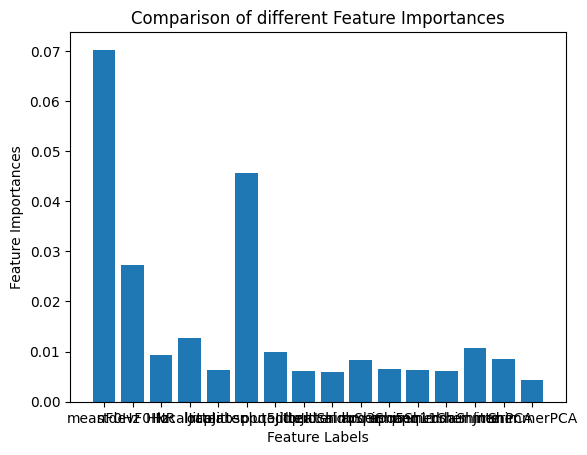

In [309]:
plt.bar(data_pd.columns, feature_importance_normalized)
plt.xlabel('Feature Labels')
plt.ylabel('Feature Importances')
plt.title('Comparison of different Feature Importances')
plt.show()

In [310]:
Sc = pd.DataFrame({"Features":columns})
Sc["values"] = feature_importance_normalized
Sc.sort_values(by="values", ascending=False,inplace = True)
Sc.reset_index(drop=True, inplace=True)

In [311]:
len(Sc)

16

In [312]:
Sc['Features']

0                meanF0Hz
1     localabsoluteJitter
2               stdevF0Hz
3             localJitter
4              ddaShimmer
5              ppq5Jitter
6                     HNR
7               JitterPCA
8          localdbShimmer
9             apq3Shimmer
10            apq5Shimmer
11              rapJitter
12           apq11Shimmer
13              ddpJitter
14           localShimmer
15             ShimmerPCA
Name: Features, dtype: object

In [313]:
# Considering the features selected by Extra tree method

dde =data_pd.copy()
for i in range(len(Sc)):    
    if  i>9:
       dde.drop(Sc['Features'][i],axis=1,inplace=True)
       Sc.reset_index(drop=True, inplace=True)
    #    data_pd.drop(["health_status","voiceID"],axis = 1,inplace = True)

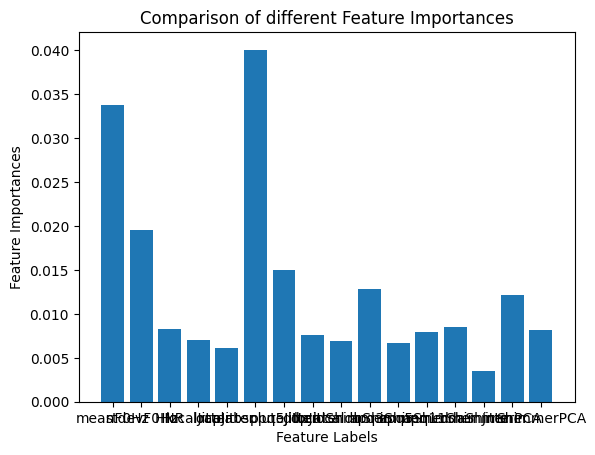

In [394]:
extra_tree_forest = ExtraTreesClassifier(n_estimators = 10,
                                        criterion ='gini') 
extra_tree_forest.fit(data_pd1, label_pd1) 
# Computing the importance of each feature
feature_importance = extra_tree_forest.feature_importances_ 
# Normalizing the individual importances
feature_importance_normalized = np.std([tree.feature_importances_ for tree in
                                        extra_tree_forest.estimators_],
                                        axis = 0)

plt.bar(data_pd1.columns, feature_importance_normalized)
plt.xlabel('Feature Labels')
plt.ylabel('Feature Importances')
plt.title('Comparison of different Feature Importances')
plt.show()

In [395]:
Sc = pd.DataFrame({"Features":columns})
Sc["values"] = feature_importance_normalized
Sc.sort_values(by="values", ascending=False,inplace = True)
Sc.reset_index(drop=True, inplace=True)
Sc['Features']

0     localabsoluteJitter
1                meanF0Hz
2               stdevF0Hz
3              ppq5Jitter
4          localdbShimmer
5               JitterPCA
6            apq11Shimmer
7                     HNR
8              ShimmerPCA
9             apq5Shimmer
10              ddpJitter
11            localJitter
12           localShimmer
13            apq3Shimmer
14              rapJitter
15             ddaShimmer
Name: Features, dtype: object

In [396]:
dde1 =data_pd1.copy()
for i in range(len(Sc)):    
    if  i>9:
       dde1.drop(Sc['Features'][i],axis=1,inplace=True)
      #  Sc.reset_index(drop=True, inplace=True)
    #    data_pd.drop(["health_status","voiceID"],axis = 1,inplace = True)

In [314]:
data_pd

,meanF0Hz,stdevF0Hz,HNR,localJitter,rapJitter,localabsoluteJitter,ppq5Jitter,ddpJitter,localShimmer,localdbShimmer,apq3Shimmer,apq5Shimmer,apq11Shimmer,ddaShimmer,JitterPCA,ShimmerPCA
0,148.044842,18.183764,10.121493,0.017511,0.006223,0.000119,0.007621,0.018669,0.096014,0.910666,0.031010,0.050483,0.097332,0.093030,-2.095849,1.049985
1,117.074562,11.102115,12.536485,0.019217,0.008018,0.000164,0.008995,0.024055,0.111276,1.032005,0.049275,0.069420,0.110007,0.147825,-0.128222,1.727862
2,103.910521,12.921080,9.926366,0.028841,0.013393,0.000276,0.016481,0.040178,0.127040,1.214776,0.049135,0.076892,0.173894,0.147404,2.558552,1.038356
3,114.162380,19.479072,13.975984,0.026645,0.012443,0.000233,0.015949,0.037329,0.120209,1.121113,0.045039,0.067634,0.170422,0.135118,1.660963,0.955175
4,120.412214,15.056519,15.395877,0.020406,0.009146,0.000170,0.012286,0.027437,0.107519,1.035589,0.036560,0.060782,0.127737,0.109681,-0.336169,1.019038
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3905,144.786070,19.104286,12.058078,0.025558,0.010305,0.000175,0.012362,0.030915,0.118697,1.107039,0.044916,0.066323,0.103365,0.134749,0.522666,0.890075
3906,138.474776,13.717472,11.946205,0.022832,0.008930,0.000163,0.011354,0.026789,0.120695,1.062326,0.049287,0.066942,0.102446,0.147860,0.313749,1.351659
3907,138.493583,32.928974,13.070959,0.022078,0.009000,0.000159,0.010375,0.027001,0.128798,1.088259,0.052964,0.073386,0.106664,0.158893,0.623444,1.786582
3908,142.690287,38.280970,11.497019,0.023356,0.010031,0.000165,0.010599,0.030092,0.147235,1.227653,0.060392,0.080453,0.117314,0.181177,1.703297,2.320439


In [397]:
dde1

,meanF0Hz,stdevF0Hz,HNR,localabsoluteJitter,ppq5Jitter,localdbShimmer,apq5Shimmer,apq11Shimmer,JitterPCA,ShimmerPCA
0,140.937953,13.244039,10.420942,0.000204,0.013689,1.593766,0.097007,0.139745,2.516216,-2.201270
1,107.822197,8.172295,9.268502,0.000386,0.025207,0.921717,0.044129,0.059732,1.357816,3.184417
2,116.239581,11.482306,13.121266,0.000195,0.010160,0.767872,0.043714,0.074681,-1.276662,0.388793
3,114.500154,13.525342,12.090962,0.000228,0.011974,0.767239,0.046868,0.075982,-0.917536,0.653908
4,107.601472,7.816628,9.583570,0.000306,0.018012,1.241381,0.072866,0.130570,2.082727,-0.144422
...,...,...,...,...,...,...,...,...,...,...
3428,175.056100,103.123774,7.117235,0.000153,0.010994,1.548866,0.134475,0.292475,3.175688,-3.536878
3429,139.522584,65.794437,7.729940,0.000232,0.015924,1.372816,0.120793,0.282836,3.512128,-2.027968
3430,122.743067,18.085431,9.787607,0.000307,0.019342,1.367820,0.103366,0.197679,3.529949,-0.527071
3431,148.523164,10.721611,10.852943,0.000127,0.009031,0.950941,0.054780,0.083514,-1.227448,-0.636827


In [315]:
dde

,meanF0Hz,stdevF0Hz,HNR,localJitter,localabsoluteJitter,ppq5Jitter,localdbShimmer,apq3Shimmer,ddaShimmer,JitterPCA
0,148.044842,18.183764,10.121493,0.017511,0.000119,0.007621,0.910666,0.031010,0.093030,-2.095849
1,117.074562,11.102115,12.536485,0.019217,0.000164,0.008995,1.032005,0.049275,0.147825,-0.128222
2,103.910521,12.921080,9.926366,0.028841,0.000276,0.016481,1.214776,0.049135,0.147404,2.558552
3,114.162380,19.479072,13.975984,0.026645,0.000233,0.015949,1.121113,0.045039,0.135118,1.660963
4,120.412214,15.056519,15.395877,0.020406,0.000170,0.012286,1.035589,0.036560,0.109681,-0.336169
...,...,...,...,...,...,...,...,...,...,...
3905,144.786070,19.104286,12.058078,0.025558,0.000175,0.012362,1.107039,0.044916,0.134749,0.522666
3906,138.474776,13.717472,11.946205,0.022832,0.000163,0.011354,1.062326,0.049287,0.147860,0.313749
3907,138.493583,32.928974,13.070959,0.022078,0.000159,0.010375,1.088259,0.052964,0.158893,0.623444
3908,142.690287,38.280970,11.497019,0.023356,0.000165,0.010599,1.227653,0.060392,0.181177,1.703297


In [317]:
label_pd

0       1
1       1
2       1
3       1
4       1
       ..
3905    0
3906    0
3907    0
3908    0
3909    0
Name: health_status, Length: 3910, dtype: int64

In [321]:
# from sklearn.impute import SimpleImputer
# imputer = SimpleImputer(strategy='mean')
# data_pd = imputer.fit_transform(data_pd)

In [327]:
# Checking the evaluation metrices while considering all the acoustic features for MDVRKCL Readtext dataset
score1 = Evaluate(data_pd,label_pd)
score1

,Classifier,Accuracy,Specificity,Sensitivity,Precision,F Measure
0,GradientBoosting,0.840491,0.944923,0.687657,0.895082,0.777778
1,RandomForest,0.839468,0.941480,0.690176,0.889610,0.777305
2,XGBoost,0.830266,0.915663,0.705290,0.851064,0.771350
3,AdaBoost,0.821063,0.898451,0.707809,0.826471,0.762551
4,KNeighbors,0.811861,0.898451,0.685139,0.821752,0.747253
5,RadialSVM,0.793456,0.929432,0.594458,0.851986,0.700297
6,LinearSVM,0.781186,0.886403,0.627204,0.790476,0.699438
7,Logistic,0.771984,0.877797,0.617128,0.775316,0.687237
8,DecisionTree,0.756646,0.802065,0.690176,0.704370,0.697201


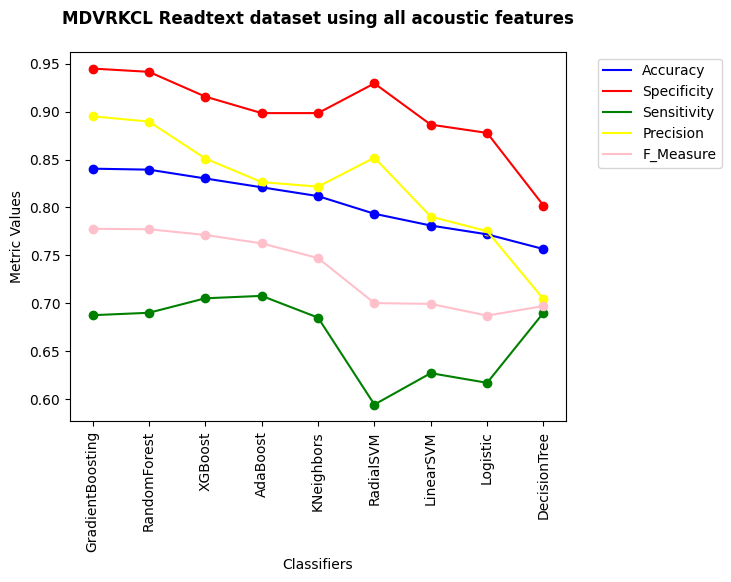

In [356]:
plt.title("MDVRKCL Readtext dataset using all acoustic features",fontweight='bold', pad=20)

plt.xlabel("Classifiers")
plt.ylabel("Metric Values")
plt.xticks(rotation="vertical")
plt.plot(score1['Classifier'], score1['Accuracy'], color='blue', label='Accuracy')
plt.plot(score1['Classifier'], score1['Specificity'], color='red', label='Specificity')
plt.plot(score1['Classifier'], score1['Sensitivity'], color='green', label='Sensitivity')
plt.plot(score1['Classifier'], score1['Precision'], color='yellow', label='Precision')
plt.plot(score1['Classifier'], score1['F Measure'] , color ='pink' , label = 'F_Measure')
plt.scatter(score1['Classifier'], score1['Accuracy'], color='blue')
plt.scatter(score1['Classifier'], score1['Specificity'], color='red')
plt.scatter(score1['Classifier'], score1['Sensitivity'], color='green')
plt.scatter(score1['Classifier'], score1['Precision'], color='yellow')
plt.scatter(score1['Classifier'], score1['F Measure'] , color ='pink')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')


In [331]:
# Checking the evaluation metrices while considering all the acoustic features selected using genetic algorithm for MDVRKCL Readtext dataset
score2 = Evaluate(dfe,label_pd)
score2

,Classifier,Accuracy,Specificity,Sensitivity,Precision,F Measure
0,RandomForest,0.835378,0.943201,0.677582,0.890728,0.769671
1,GradientBoosting,0.832311,0.944923,0.667506,0.892256,0.763689
2,AdaBoost,0.825153,0.905336,0.707809,0.836310,0.766712
3,XGBoost,0.816973,0.910499,0.680101,0.838509,0.751043
4,KNeighbors,0.803681,0.891566,0.675063,0.809668,0.736264
5,RadialSVM,0.795501,0.931153,0.596977,0.855596,0.703264
6,DecisionTree,0.782209,0.829604,0.712846,0.740838,0.726573
7,LinearSVM,0.781186,0.896730,0.612091,0.801980,0.694286
8,Logistic,0.778119,0.886403,0.619647,0.788462,0.693935


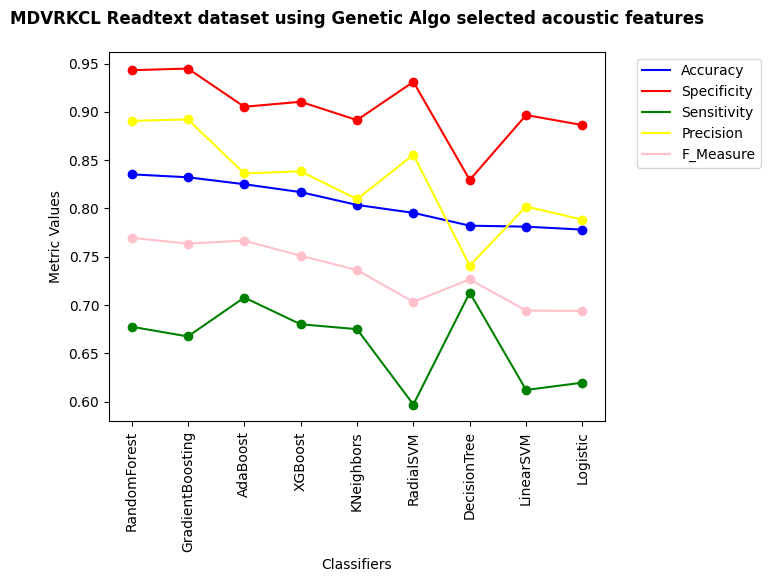

In [355]:
plt.title("MDVRKCL Readtext dataset using Genetic Algo selected acoustic features",fontweight='bold', pad=20)

plt.xlabel("Classifiers")
plt.ylabel("Metric Values")

plt.xticks(rotation="vertical")
plt.plot(score2['Classifier'], score2['Accuracy'], color='blue', label='Accuracy')
plt.plot(score2['Classifier'], score2['Specificity'], color='red', label='Specificity')
plt.plot(score2['Classifier'], score2['Sensitivity'], color='green', label='Sensitivity')
plt.plot(score2['Classifier'], score2['Precision'], color='yellow', label='Precision')
plt.plot(score2['Classifier'], score2['F Measure'] , color ='pink' , label = 'F_Measure')

plt.scatter(score2['Classifier'], score2['Accuracy'], color='blue')
plt.scatter(score2['Classifier'], score2['Specificity'], color='red')
plt.scatter(score2['Classifier'], score2['Sensitivity'], color='green')
plt.scatter(score2['Classifier'], score2['Precision'], color='yellow')
plt.scatter(score2['Classifier'], score2['F Measure'] , color ='pink')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')


In [333]:
# Checking the evaluation metrices while considering all the acoustic features selected using Extra tree algorithm for MDVRKCL Readtext dataset
score3 = Evaluate(dde,label_pd)
score3

,Classifier,Accuracy,Specificity,Sensitivity,Precision,F Measure
0,XGBoost,0.842536,0.929432,0.715365,0.873846,0.786704
1,RandomForest,0.839468,0.946644,0.682620,0.897351,0.775393
2,GradientBoosting,0.829243,0.941480,0.664987,0.885906,0.759712
3,AdaBoost,0.812883,0.895009,0.692695,0.818452,0.750341
4,KNeighbors,0.810838,0.896730,0.685139,0.819277,0.746228
5,RadialSVM,0.796524,0.932874,0.596977,0.858696,0.704309
6,LinearSVM,0.784254,0.891566,0.627204,0.798077,0.702398
7,Logistic,0.774029,0.877797,0.622166,0.776730,0.690909
8,DecisionTree,0.768916,0.812392,0.705290,0.719794,0.712468


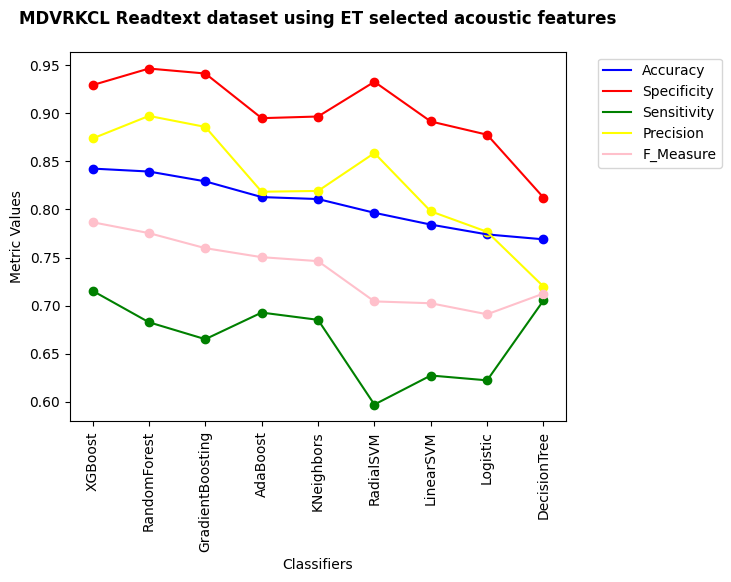

In [354]:
plt.title("MDVRKCL Readtext dataset using ET selected acoustic features",fontweight='bold', pad=20)
plt.xlabel("Classifiers")
plt.ylabel("Metric Values")
plt.xticks(rotation="vertical")

plt.plot(score3['Classifier'], score3['Accuracy'], color='blue', label='Accuracy')
plt.plot(score3['Classifier'], score3['Specificity'], color='red', label='Specificity')
plt.plot(score3['Classifier'], score3['Sensitivity'], color='green', label='Sensitivity')
plt.plot(score3['Classifier'], score3['Precision'], color='yellow', label='Precision')
plt.plot(score3['Classifier'], score3['F Measure'] , color ='pink' , label = 'F_Measure')
plt.scatter(score3['Classifier'], score3['Accuracy'], color='blue')
plt.scatter(score3['Classifier'], score3['Specificity'], color='red')
plt.scatter(score3['Classifier'], score3['Sensitivity'], color='green')
plt.scatter(score3['Classifier'], score3['Precision'], color='yellow')
plt.scatter(score3['Classifier'], score3['F Measure'] , color ='pink')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# Increase the size of the plot area
# plt.tight_layout()
# pltlegend()



In [398]:
# Checking the evaluation metrices while considering all the acoustic features for MDVRKCL Spontaneous dataset
score4 = Evaluate(data_pd1,label_pd1) 
score4

,Classifier,Accuracy,Specificity,Sensitivity,Precision,F Measure
0,XGBoost,0.814901,0.890756,0.720627,0.841463,0.776371
1,RandomForest,0.796275,0.899160,0.668407,0.842105,0.745269
2,GradientBoosting,0.782305,0.901261,0.634465,0.837931,0.722140
3,LinearSVM,0.749709,0.844538,0.631854,0.765823,0.692418
4,RadialSVM,0.749709,0.936975,0.516971,0.868421,0.648118
5,AdaBoost,0.748545,0.869748,0.597911,0.786942,0.679525
6,Logistic,0.747381,0.827731,0.647520,0.751515,0.695652
7,KNeighbors,0.741560,0.848739,0.608355,0.763934,0.677326
8,DecisionTree,0.734575,0.750000,0.715405,0.697201,0.706186


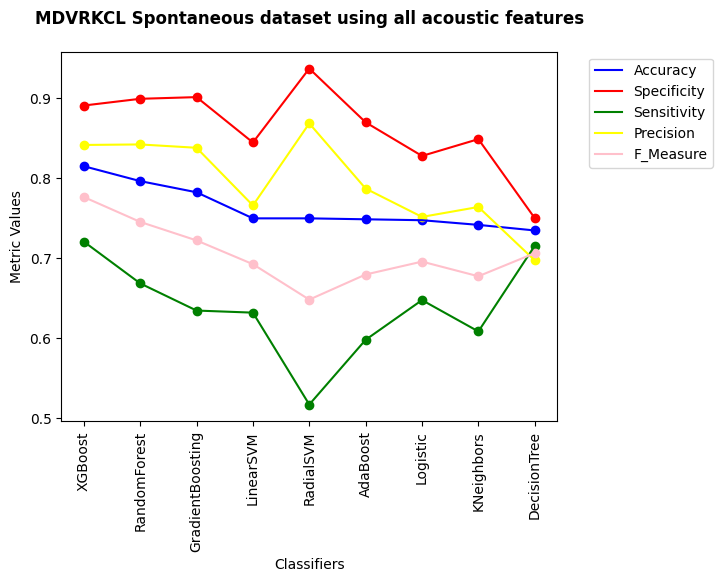

In [399]:
plt.title("MDVRKCL Spontaneous dataset using all acoustic features",fontweight='bold', pad=20)

plt.xlabel("Classifiers")
plt.ylabel("Metric Values")
plt.xticks(rotation="vertical")
plt.plot(score4['Classifier'], score4['Accuracy'], color='blue', label='Accuracy')
plt.plot(score4['Classifier'], score4['Specificity'], color='red', label='Specificity')
plt.plot(score4['Classifier'], score4['Sensitivity'], color='green', label='Sensitivity')
plt.plot(score4['Classifier'], score4['Precision'], color='yellow', label='Precision')
plt.plot(score4['Classifier'], score4['F Measure'] , color ='pink' , label = 'F_Measure')
plt.scatter(score4['Classifier'], score4['Accuracy'], color='blue')
plt.scatter(score4['Classifier'], score4['Specificity'], color='red')
plt.scatter(score4['Classifier'], score4['Sensitivity'], color='green')
plt.scatter(score4['Classifier'], score4['Precision'], color='yellow')
plt.scatter(score4['Classifier'], score4['F Measure'] , color ='pink')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')


In [400]:
# Checking the evaluation metrices while considering all the acoustic features selected using genetic algorithm for MDVRKCL Spontaneous dataset
score5 = Evaluate(dfe1,label_pd1)
score5

,Classifier,Accuracy,Specificity,Sensitivity,Precision,F Measure
0,RandomForest,0.764843,0.867647,0.637076,0.794788,0.707246
1,XGBoost,0.746217,0.804622,0.673629,0.735043,0.702997
2,AdaBoost,0.736903,0.806723,0.650131,0.730205,0.687845
3,GradientBoosting,0.732247,0.829832,0.610966,0.742857,0.670487
4,LinearSVM,0.678696,0.817227,0.506527,0.690391,0.584337
5,DecisionTree,0.675204,0.710084,0.631854,0.636842,0.634338
6,Logistic,0.671711,0.804622,0.506527,0.675958,0.579104
7,RadialSVM,0.654249,0.802521,0.469974,0.656934,0.547945
8,KNeighbors,0.637951,0.775210,0.467363,0.625874,0.535127


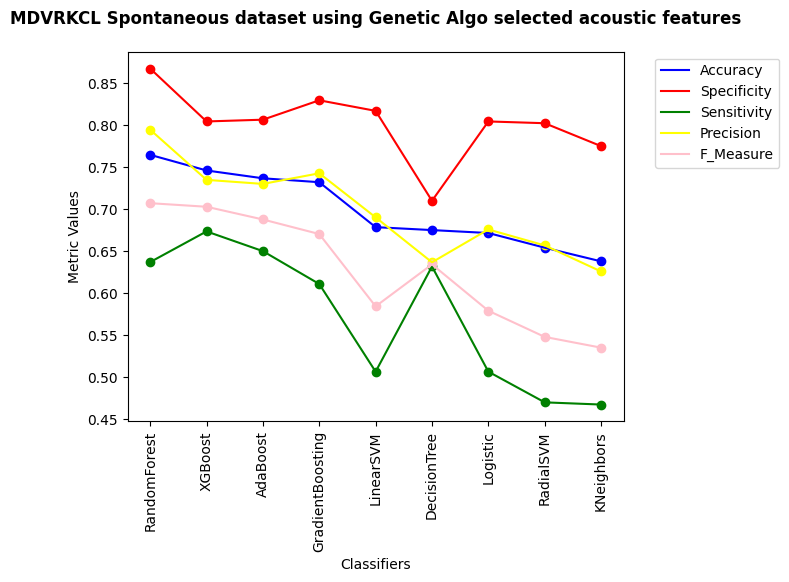

In [401]:
plt.title("MDVRKCL Spontaneous dataset using Genetic Algo selected acoustic features",fontweight='bold', pad=20)

plt.xlabel("Classifiers")
plt.ylabel("Metric Values")
plt.xticks(rotation="vertical")
plt.plot(score5['Classifier'], score5['Accuracy'], color='blue', label='Accuracy')
plt.plot(score5['Classifier'], score5['Specificity'], color='red', label='Specificity')
plt.plot(score5['Classifier'], score5['Sensitivity'], color='green', label='Sensitivity')
plt.plot(score5['Classifier'], score5['Precision'], color='yellow', label='Precision')
plt.plot(score5['Classifier'], score5['F Measure'] , color ='pink' , label = 'F_Measure')
plt.scatter(score5['Classifier'], score5['Accuracy'], color='blue')
plt.scatter(score5['Classifier'], score5['Specificity'], color='red')
plt.scatter(score5['Classifier'], score5['Sensitivity'], color='green')
plt.scatter(score5['Classifier'], score5['Precision'], color='yellow')
plt.scatter(score5['Classifier'], score5['F Measure'] , color ='pink')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')


In [402]:
# Checking the evaluation metrices while considering all the acoustic features selected using Extra tree algorithm for MDVRKCL Spontaneous dataset
score6 = Evaluate(dde1,label_pd1)
score6

,Classifier,Accuracy,Specificity,Sensitivity,Precision,F Measure
0,XGBoost,0.805588,0.890756,0.699739,0.837500,0.762447
1,RandomForest,0.802095,0.897059,0.684073,0.842444,0.755043
2,GradientBoosting,0.791618,0.911765,0.642298,0.854167,0.733234
3,LinearSVM,0.752037,0.846639,0.634465,0.768987,0.695279
4,Logistic,0.750873,0.834034,0.647520,0.758410,0.698592
5,RadialSVM,0.748545,0.936975,0.514360,0.867841,0.645902
6,AdaBoost,0.747381,0.867647,0.597911,0.784247,0.678519
7,DecisionTree,0.747381,0.771008,0.718016,0.716146,0.717080
8,KNeighbors,0.741560,0.848739,0.608355,0.763934,0.677326


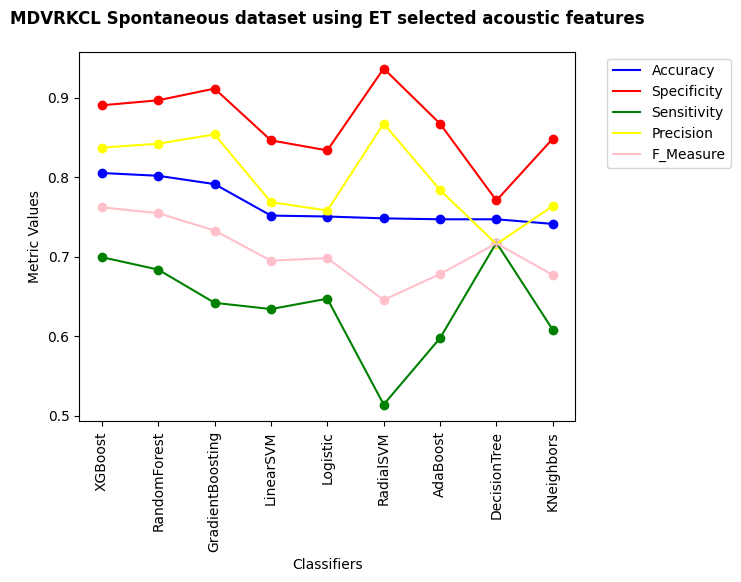

In [403]:
plt.title("MDVRKCL Spontaneous dataset using ET selected acoustic features",fontweight='bold', pad=20)
plt.xlabel("Classifiers")
plt.ylabel("Metric Values")
plt.xticks(rotation="vertical")

plt.plot(score6['Classifier'], score6['Accuracy'], color='blue', label='Accuracy')
plt.plot(score6['Classifier'], score6['Specificity'], color='red', label='Specificity')
plt.plot(score6['Classifier'], score6['Sensitivity'], color='green', label='Sensitivity')
plt.plot(score6['Classifier'], score6['Precision'], color='yellow', label='Precision')
plt.plot(score6['Classifier'], score6['F Measure'] , color ='pink' , label = 'F_Measure')
plt.scatter(score6['Classifier'], score6['Accuracy'], color='blue')
plt.scatter(score6['Classifier'], score6['Specificity'], color='red')
plt.scatter(score6['Classifier'], score6['Sensitivity'], color='green')
plt.scatter(score6['Classifier'], score6['Precision'], color='yellow')
plt.scatter(score6['Classifier'], score6['F Measure'] , color ='pink')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
